# Forecasting Volcanic Eruption and Impact Assessment

## Problem Statement

The problem at hand entails analyzing a sequence of sensor readings taken at consecutive time steps to address two distinct tasks related to volcanic eruptions. Firstly, the aim is to devise an effective approach that accurately estimates the remaining time units until eruption for a given observation. This observation can have sensor readings of varying lengths. By leveraging the information within the sensor data, the objective is to provide timely predictions for the impending eruption, enabling proactive measures to be taken to ensure the safety of affected areas and populations.

The second task involves estimating the magnitude of the impending volcanic eruption. Utilizing the provided observation, the goal is to develop a methodology that can estimate the severity and intensity of the eruption event. Despite the absence of the eruption magnitude in the observations, it is possible to estimate the tilt erupt value, which represents the last sensor reading corresponding to the moment of eruption. This particular value exhibits a strong correlation with the magnitude of the eruption. By estimating the tilt erupt value, we can obtain a reliable estimation of the eruption's impact. The obtained estimation is crucial for emergency management and response planning, allowing authorities to allocate appropriate resources and implement necessary measures to mitigate the potential impacts of the volcanic eruption on surrounding areas.

## Importing required libraries

In [296]:
from collections import namedtuple
import re
import os
import random
import pandas as pd
import numpy as np
from tsfresh import extract_relevant_features, extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNetCV, PoissonRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from lazypredict.Supervised import LazyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.pipeline import Pipeline
from typing import Callable
from collections import defaultdict
from pprint import pprint
from IPython.display import display
from tqdm import tqdm

## Read in data

Store the data we need in a list of namedtuples, with each item corresponding to an observation. From each observation we need the tilt_erupt, the times, and the pressures.

Note that I ran into repeated time indices once (in volcano 6, observation 11, time index -175 is repeated twice), so I'm creating that on my own. If there's a problem with the pressure, there's not much I can do about it at this point.

In [4]:
ObservationData = namedtuple('ObservationData', ['tilt_erupt', 'time', 'pressure', 'observation'])
def read_volcano_data(dataset_root):
    data = defaultdict(list)
    for root, dirs, files in os.walk(dataset_root):
        for file in files:
            fpath = os.path.join(root, file)
            with open(fpath, 'r') as f:
                volcano = root[root.rfind('V'):]
                observation = file[:file.rfind('.')]
                fdata = f.readlines()
                pressure = np.fromstring(fdata[-1], sep=',')
                time = np.arange(-len(pressure)+1, 1)
                tilt_erupt = pressure[-1]
                obs_data = ObservationData(tilt_erupt=tilt_erupt, time=time, pressure=pressure, observation=observation)
                data[volcano].append(obs_data)
    return data

data = read_volcano_data('./Volcano_Dataset')

## Visual Data Examination

Let's view the pressure vs time for some of the eruptions to get an understanding of what we're dealing with and see if there's anything obvious that would help with the predictions.

For the most part, the pressure appears to be farily flat before the eruption. In some cases, there's a dip in the pressure before the eruption. Otherwise, there is no obvious indicator that a volcano is about to erupt.

In [5]:
for volcano, obs in data.items():
    print(f'{volcano}: {len(obs)}')

Volcano1: 12
Volcano10: 30
Volcano2: 27
Volcano3: 30
Volcano4: 15
Volcano5: 3
Volcano6: 27
Volcano7: 12
Volcano8: 21
Volcano9: 12


We can see in the plots below that there is a wide variation in the evolution of the pressure for different eruptions, even for the same volcano. This variation may prove troublesome, and may need to be handled by removing outliers.

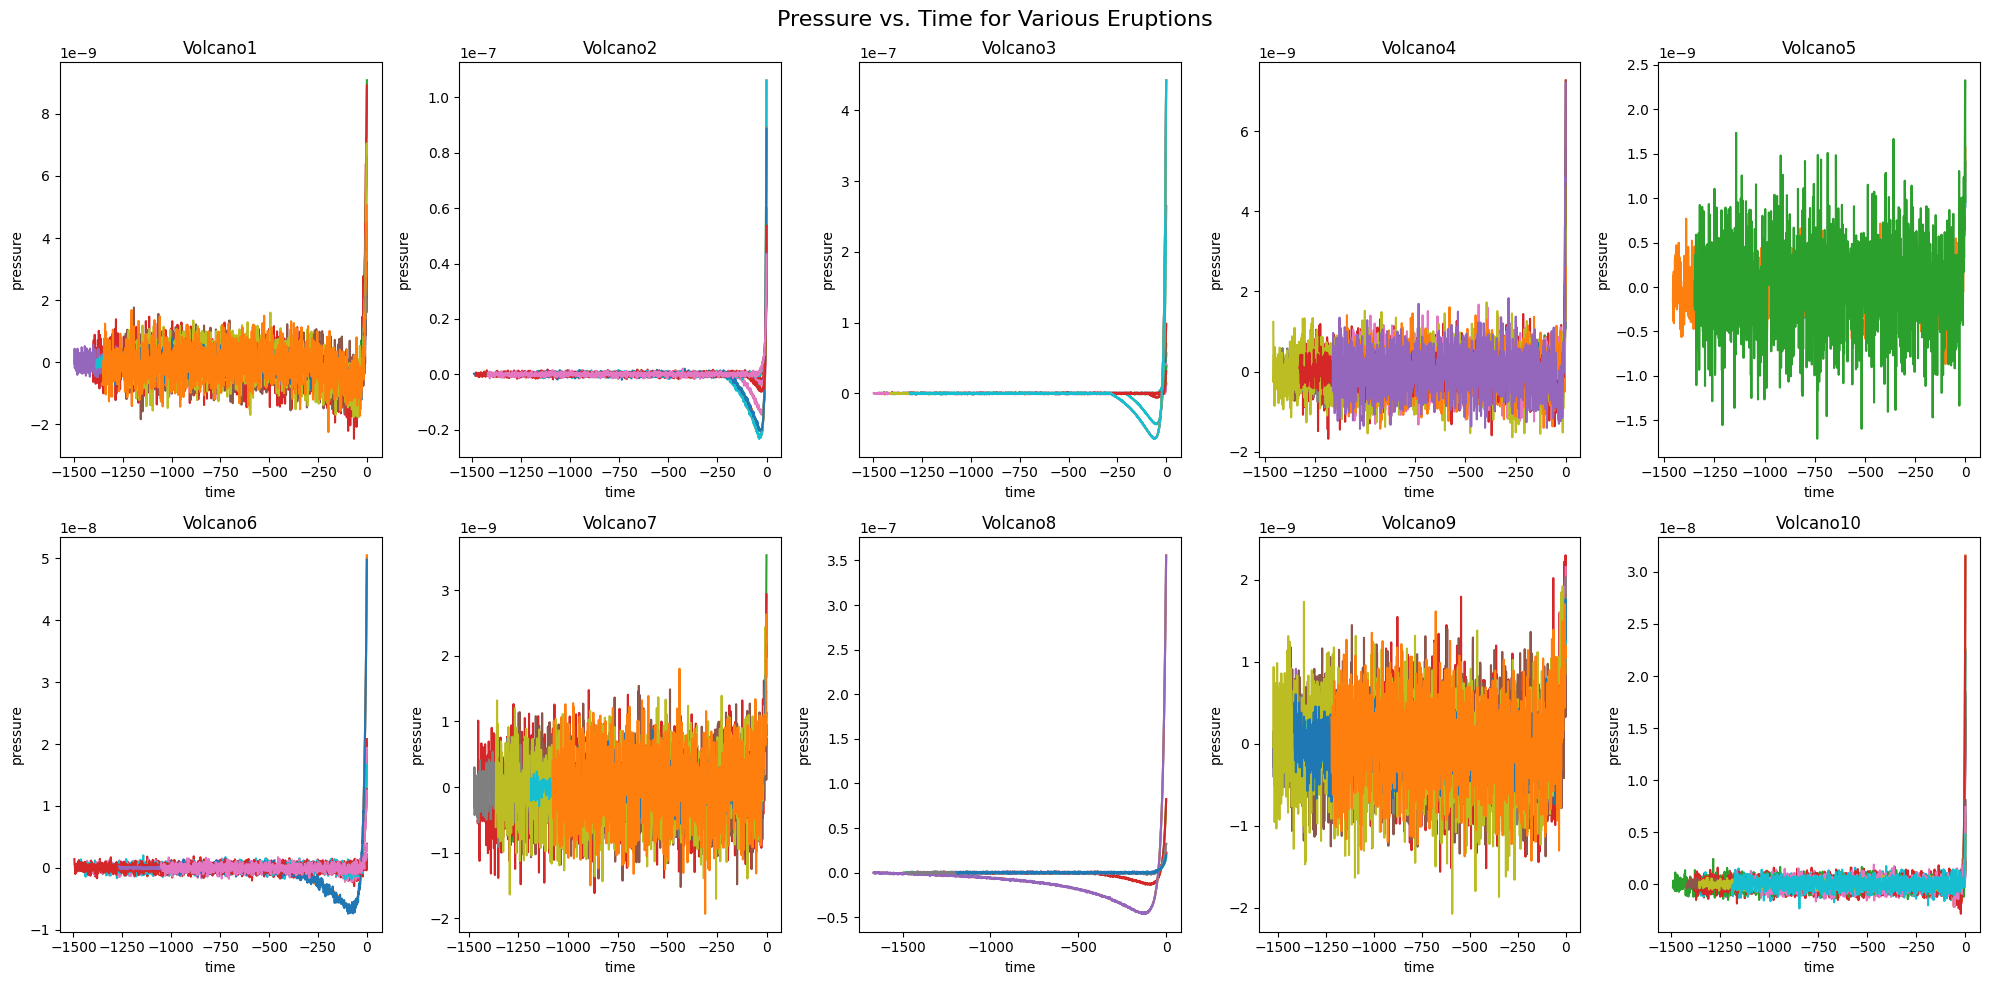

In [6]:
width = 5

fig, axs = plt.subplots((len(data)+width-1)//width, width, figsize=(20, 10))
for i in range(len(data)):
    volcano = 'Volcano'+str(i+1)
    for obs in data[volcano]:
        axs[i//width, i%width].plot(obs.time, obs.pressure)
    axs[i//width, i%width].set_xlabel('time')
    axs[i//width, i%width].set_ylabel('pressure')
    axs[i//width, i%width].set_title(volcano)

fig.suptitle('Pressure vs. Time for Various Eruptions', fontsize=16)
fig.tight_layout()

## Test Data

Extract some test observations for the final model evaluation and validation observations for validating various models and techniques. Note that I extract the test data before extracting time sequences from the observations. Doing otherwise would be cheating, as time sequences from the same observation are likely to be correlated.

I use a 60/20/20 train/validate/test split.

In [372]:
data_train = []
data_validate = []
data_test = []
for i, obs in enumerate(data.values()):
    temp_train_and_validate, temp_test = train_test_split(obs, test_size=0.2, random_state=40+i)
    temp_train, temp_validate = train_test_split(temp_train_and_validate, test_size=0.25, random_state=50+i)
    data_train.extend(temp_train)
    data_validate.extend(temp_validate)
    data_test.extend(temp_test)

# for EDA
data_train_and_validate = []
data_train_and_validate.extend(data_train)
data_train_and_validate.extend(data_validate)

print(f'Number train observations: {len(data_train)}')
print(f'Number validate obeservations: {len(data_validate)}')
print(f'Number test observations: {len(data_test)}')

Number train observations: 106
Number validate obeservations: 41
Number test observations: 42


## Time Sequence Extraction

To be useful, the data needs to be transformed into features and a corresponding result that a model can work with. To do so, I first break up the pressure observation into shorter sequences of specified length, then I extract some features from those sequences below. Here, I code up three ways of extracting sequences:

1. sequential: The sequences are consecutive and non-overlapping. The first sequence extraction is shifted so that the last sequence includes time 0.
2. overlapping: Each consecutive sequence overlaps with the previous but is offset by 25 time-steps by default. As with the sequential sequences, the first sequence extraction is shifted so that the last sequence includes time 0.
3. random: A number of sequences equal to the observation length divided by 100 (rounded to the nearest integer) are extracted. The start point of each sequence is chosen at random, but has an upper bound such that an entire sequence can be extracted (e.g. a sequence of length 100 cannot start at time=-50).

In [161]:
def convert_series_to_sequences(eruptions: list, seq_len: int, type='overlap', overlap_step=25, random_seed=5):
    random.seed(random_seed)
    sequences = []
    time_remaining = []
    tilt_erupt = []
    seq_id_start = 0
    for erupt_data in eruptions:
        obs_len = len(erupt_data.pressure)
        if type=='sequential':
            start_offset = obs_len % seq_len
            sequences0, time_remaining0, tilt_erupt0 = observation_sequences(erupt_data, seq_id_start, seq_len, start_offset, seq_len)
        elif type=='overlap':
            start_offset = (obs_len-seq_len) % overlap_step
            sequences0, time_remaining0, tilt_erupt0 = observation_sequences(erupt_data, seq_id_start, seq_len, start_offset, overlap_step)
        elif type=='random':
            sequences0, time_remaining0, tilt_erupt0 = observation_sequences_random(erupt_data, seq_id_start, seq_len)
        else:
            raise Exception('Not a valid sequence extraction type.')
        sequences.extend(sequences0)
        time_remaining.extend(time_remaining0)
        tilt_erupt.extend(tilt_erupt0)
        seq_id_start = sequences0[-1]['sequence id'][0] + 1

    sequences_df = pd.concat(sequences, ignore_index=True)
    time = pd.Series(time_remaining, name='time remaining')
    tilt_erupt = pd.Series(tilt_erupt, name='tilt erupt')
    return sequences_df, time, tilt_erupt

def observation_sequences(obs: ObservationData, seq_id_start: int, seq_len: int, start_offset: int, step_len: int):
    seq_id = seq_id_start
    seqs_dfs = []
    time_remaining = []
    tilt_erupt = []
    obs_len = len(obs.pressure)
    for i in range((obs_len-seq_len) // step_len + 1):
        seq_data = {}
        seq_data['sequence id'] = seq_id*np.ones(seq_len, dtype=pd.Int32Dtype)
        seq_id += 1
        start = start_offset + i*step_len
        seq_data['time'] = obs.time[start:start+seq_len]
        seq_data['pressure'] = obs.pressure[start:start+seq_len]
        seq_df = pd.DataFrame(data=seq_data)
        seqs_dfs.append(seq_df)
        time_remaining.append(-obs.time[start+seq_len-1])
        tilt_erupt.append(obs.tilt_erupt)
        
    return seqs_dfs, time_remaining, tilt_erupt

def observation_sequences_random(obs: ObservationData, seq_id_start: int, seq_len: int):
    seq_id = seq_id_start
    seqs_dfs = []
    time_remaining = []
    tilt_erupt = []
    obs_len = len(obs.pressure)
    start_max = obs_len - seq_len
    n_random_sequences = round(obs_len / 50)
    for _ in range(n_random_sequences):
        seq_data = {}
        seq_data['sequence id'] = seq_id*np.ones(seq_len, dtype=pd.Int32Dtype)
        seq_id += 1
        start = random.randint(0, start_max)
        seq_data['time'] = obs.time[start:start+seq_len]
        seq_data['pressure'] = obs.pressure[start:start+seq_len]
        seq_df = pd.DataFrame(data=seq_data)
        seqs_dfs.append(seq_df)
        time_remaining.append(-obs.time[start+seq_len-1])
        tilt_erupt.append(obs.tilt_erupt)
        
    return seqs_dfs, time_remaining, tilt_erupt
    

For exploratory data analysis, I use a sequence length of 300 with overlapping features. The sequence length is chosen based on some runs with LazyPredict later in the notebook. I choose overlapping features because they ensure lots of data is extracted from each observation, providing a good representation of the variation in each observation.

Note that the pressure sequences are all concatenated into a single data series, with each sequence labeled by a sequence id. This arrangement is required by TSFresh.

In [11]:
eda_seq_len = 300
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=eda_seq_len, type='overlap')

In [12]:
pd.options.display.float_format = None
pressure_seqs

sequence id  time  pressure
0                 0 -1199  3.12e-11
1                 0 -1198  3.93e-11
2                 0 -1197 -9.06e-11
3                 0 -1196  1.46e-10
4                 0 -1195 -4.75e-11
...             ...   ...       ...
1767895        5892    -4  6.51e-10
1767896        5892    -3  1.10e-09
1767897        5892    -2  6.06e-10
1767898        5892    -1  3.25e-10
1767899        5892     0  1.41e-09

[1767900 rows x 3 columns]

In [13]:
y_time

0       900
1       875
2       850
3       825
4       800
       ... 
5888    100
5889     75
5890     50
5891     25
5892      0
Name: time remaining, Length: 5893, dtype: int64

In [14]:
y_tilt_erupt

0       8.82e-09
1       8.82e-09
2       8.82e-09
3       8.82e-09
4       8.82e-09
          ...   
5888    1.41e-09
5889    1.41e-09
5890    1.41e-09
5891    1.41e-09
5892    1.41e-09
Name: tilt erupt, Length: 5893, dtype: float64

### Manual Feature Extraction

To be useful, the data needs to be transformed into features and a corresponding result that a model can work with. To do so, we break the pressure up into subsequences of a specified length, then perform some calculations of that subsequence to get the features. The time at the end of the subsequence is the time to eruption that we're trying to predict.

The features chosen in this case are:
* Mean
* Median
* Min
* Max
* 25th percentile
* 75th percentile
* Standard Deviation (with 1 degree of freedom)
* Variance (with 1 degree of freedom)
* Skewness
* Kurtosis
* The four coefficients of a 3rd order polynomial fit to the time sequence data
* Moving averages of length 40 every 10 timesteps

Note that the polynomial fit was a basic attempt to get some time-series features into the model. TSFresh should do a much better job of that below.

I explore paring these down after analyzing them for correlations below.

In [15]:
def extract_manual_features(pressure_seqs, y_time, y_tilt_erupt, polynomial_order=3, mv_avg_len=40, mv_avg_step=10):
    seq_len = (pressure_seqs['sequence id'] == 0).sum()
    n_mv_avg = (seq_len - mv_avg_len) // mv_avg_step + 1
    obs_series = []
    for seq_id in range(pressure_seqs['sequence id'].iloc[-1]+1):
        seq = pressure_seqs['pressure'][seq_id*seq_len:(seq_id+1)*seq_len]
        series = {}
        series['mean'] = np.mean(seq)
        series['median'] = np.median(seq)
        series['min'] = np.min(seq)
        series['max'] = np.max(seq)
        series['25th percentile'] = np.percentile(seq, 25)
        series['75th percentile'] = np.percentile(seq, 75)
        series['std dev'] = np.std(seq, ddof=1)
        series['variance'] = np.var(seq, ddof=1)
        series['skew'] = st.skew(seq)
        series['kurtosis'] = st.kurtosis(seq)
        t = np.linspace(0, len(seq)-1, len(seq))
        poly_fit = np.polynomial.polynomial.Polynomial.fit(t, seq, polynomial_order)
        for j, coef in enumerate(poly_fit.convert().coef):
            series[f'poly coef {j}'] = coef
        
        # moving averages
        for avg_i in range(n_mv_avg):
            start = avg_i * mv_avg_step
            end = start + mv_avg_len
            series['moving avg ' + str(avg_i+1)] = np.mean(seq[start:end])
            
        series['time remaining'] = y_time[seq_id]
        series['tilt erupt'] = y_tilt_erupt[seq_id]
        
        series = pd.Series(data = series).to_frame().T
        obs_series.append(series)

    df = pd.concat(obs_series, ignore_index=True)
    df['time remaining'] = df['time remaining'].astype('int32')
    return df

df = extract_manual_features(pressure_seqs, y_time, y_tilt_erupt)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5893 entries, 0 to 5892
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean             5893 non-null   float64
 1   median           5893 non-null   float64
 2   min              5893 non-null   float64
 3   max              5893 non-null   float64
 4   25th percentile  5893 non-null   float64
 5   75th percentile  5893 non-null   float64
 6   std dev          5893 non-null   float64
 7   variance         5893 non-null   float64
 8   skew             5893 non-null   float64
 9   kurtosis         5893 non-null   float64
 10  poly coef 0      5893 non-null   float64
 11  poly coef 1      5893 non-null   float64
 12  poly coef 2      5893 non-null   float64
 13  poly coef 3      5893 non-null   float64
 14  moving avg 1     5893 non-null   float64
 15  moving avg 2     5893 non-null   float64
 16  moving avg 3     5893 non-null   float64
 17  moving avg 4  

In [17]:
df.describe()

mean    median       min       max  25th percentile  \
count  5.89e+03  5.89e+03  5.89e+03  5.89e+03         5.89e+03   
mean  -5.24e-10 -4.83e-10 -1.97e-09  1.83e-09        -9.41e-10   
std    3.09e-09  3.07e-09  6.11e-09  1.71e-08         4.38e-09   
min   -3.67e-08 -3.74e-08 -6.42e-08 -2.54e-08        -4.71e-08   
25%   -1.64e-11 -1.90e-11 -1.42e-09  3.08e-10        -3.32e-10   
50%   -9.39e-13 -1.29e-12 -7.69e-10  7.08e-10        -1.79e-10   
75%    8.22e-12  1.05e-11 -3.54e-10  1.34e-09        -7.72e-11   
max    2.26e-09  2.55e-10 -1.98e-10  4.43e-07        -3.35e-11   

       75th percentile   std dev  variance     skew  kurtosis  ...  \
count         5.89e+03  5.89e+03  5.89e+03  5893.00   5893.00  ...   
mean         -1.51e-10  6.80e-10  9.33e-18     0.06      0.92  ...   
std           2.41e-09  2.98e-09  1.60e-16     0.91      6.94  ...   
min          -3.14e-08  8.60e-11  7.39e-21    -4.96     -1.41  ...   
25%           6.93e-11  1.06e-10  1.12e-20    -0.13     -0.21  ...   
50%           1.65e-10  2.55e-10  6.48e-20    -0.01     -0.04  ...   
75%           3.01e-10  4.99e-10  2.49e-19     0.09      0.18  ...   
max           9.56e-10  6.83e-08  4.67e-15    10.47    121.33  ...   

       moving avg 20  moving avg 21  moving avg 22  moving avg 23  \
count       5.89e+03       5.89e+03       5.89e+03       5.89e+03   
mean       -7.20e-10      -7.64e-10      -8.06e-10      -8.44e-10   
std         4.31e-09       4.51e-09       4.70e-09       4.87e-09   
min        -5.52e-08      -5.87e-08      -6.10e-08      -6.14e-08   
25%        -4.06e-11      -4.01e-11      -4.26e-11      -4.23e-11   
50%        -5.00e-12      -4.97e-12      -4.83e-12      -4.68e-12   
75%         2.00e-11       1.91e-11       1.96e-11       1.91e-11   
max         2.92e-10       3.92e-10       7.96e-10       1.46e-09   

       moving avg 24  moving avg 25  moving avg 26  moving avg 27  \
count       5.89e+03       5.89e+03       5.89e+03       5.89e+03   
mean       -8.74e-10      -8.81e-10      -8.41e-10      -6.64e-10   
std         5.00e-09       5.08e-09       5.21e-09       6.32e-09   
min        -6.01e-08      -6.16e-08      -6.02e-08      -6.10e-08   
25%        -4.56e-11      -4.45e-11      -4.27e-11      -4.40e-11   
50%        -5.10e-12      -5.59e-12      -4.88e-12      -4.24e-12   
75%         1.89e-11       2.00e-11       2.04e-11       2.24e-11   
max         2.40e-09       2.24e-08       6.34e-08       1.32e-07   

       time remaining  tilt erupt  
count         5893.00    5.89e+03  
mean           500.74    5.08e-08  
std            309.25    1.01e-07  
min              0.00    7.37e-10  
25%            250.00    2.82e-09  
50%            500.00    1.66e-08  
75%            750.00    4.29e-08  
max           1350.00    4.43e-07  

[8 rows x 43 columns]

## Multicollinearity

The correlation heatmap displays the correlation between features. In this one, we can see that many features are correlated.

Text(0.5, 1.0, 'Correlation Heatmap')

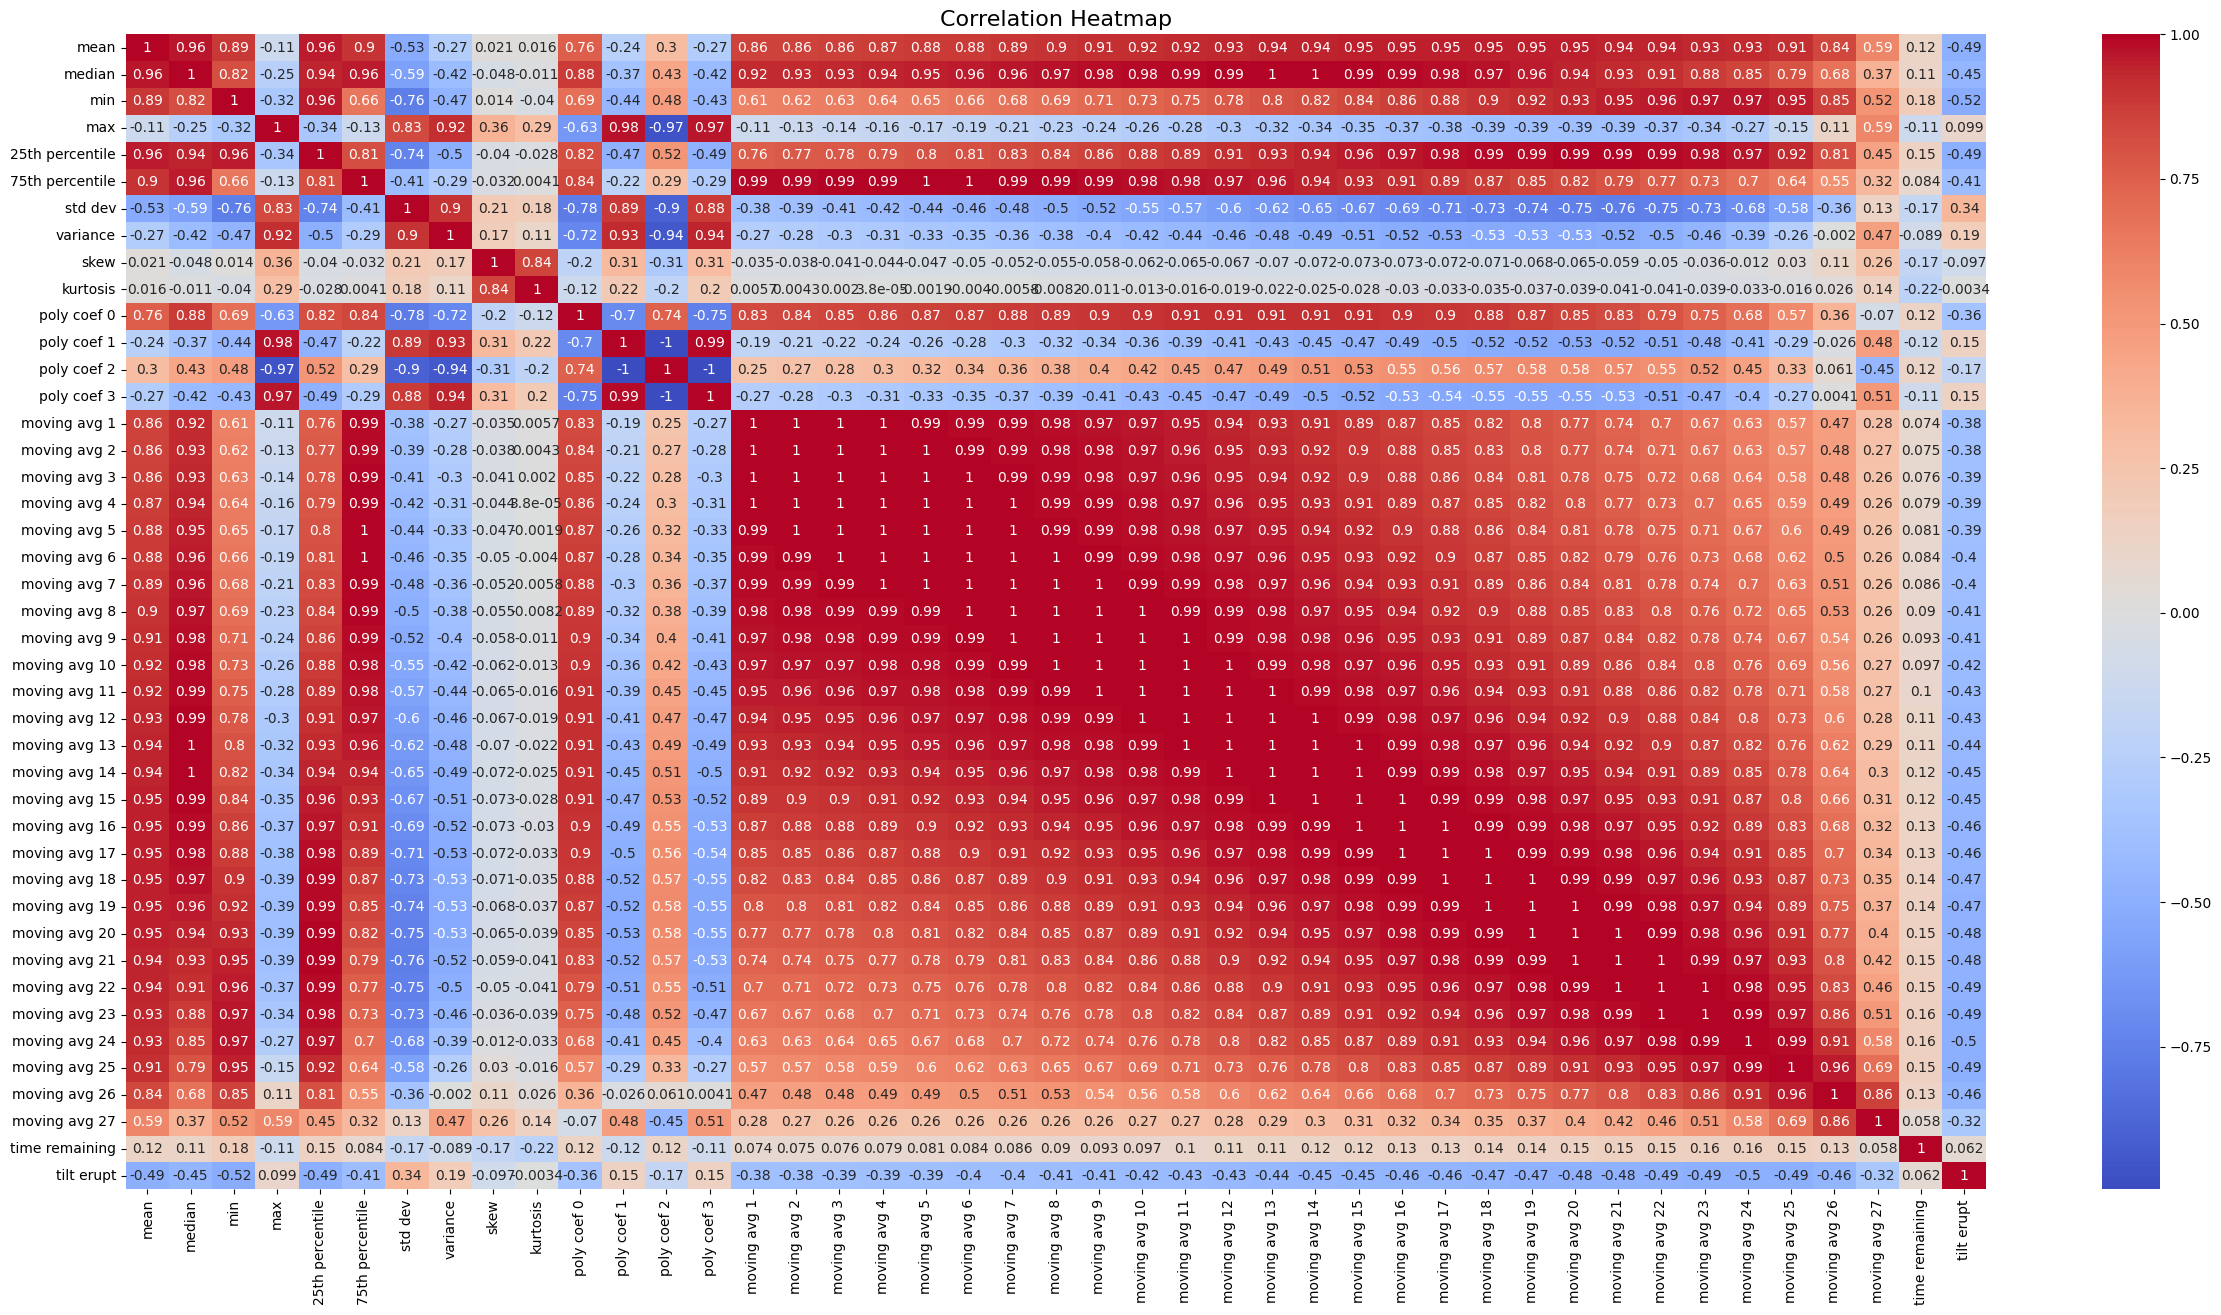

In [185]:
df = extract_manual_features(*convert_series_to_sequences(data_train_and_validate, seq_len=eda_seq_len, type='overlap'))
corr = df.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16)

#### Variance Inflation Factor and Condition Index

To deal with multicollinearity in an automated fashion, we can use the variance inflation factor (VIF). We remove any feature with a VIF > 10. However, we should only remove one feature at a time (the one with the largest VIF) then re-calculate the VIF, as removing a feature affects the VIFs for the other features.

As an alternative, we can use the condition index (based on the eigenvalues of the correlation matrix) to determine multicollinearity. When the condition index > 30, we have strong multicollinearity.

The VIF reduces the number of features to five, and the condition index also reduces them to five. Tests later on will determine whether one set of features performs better than the other.

There are other options for multicollinearity metrics, which I do not explore here.

In [186]:
def vif_series(X_data):
    X_data = X_data.assign(const=1)
    vifs = pd.Series([variance_inflation_factor(X_data.values, i) 
               for i in range(X_data.shape[1])], 
              index=X_data.columns)
    return vifs.drop(labels='const')

def condition_index_series(X_data):
    corr = X_data.corr()
    eigenvalues = np.linalg.eigvals(corr)
    return pd.Series(np.sqrt(np.max(eigenvalues)/eigenvalues), index=X_data.columns)

def uncorrelated_features(df_correlated, threshold, metric_function=vif_series):
    if 'time remaining' in df_correlated.columns:
        X_working = df_correlated.drop(columns=['time remaining', 'tilt erupt'])
    else:
        X_working = df_correlated.copy()
    
    metrics = metric_function(X_working)
    cols_to_drop = []
    while metrics.max() > threshold:
        cols_to_drop.append(metrics.idxmax())
        X_working.drop(columns=[metrics.idxmax()], inplace=True)
        metrics = metric_function(X_working)
    
    return cols_to_drop, metrics



<u>Variance Inflation Factor</u>

In [187]:
columns_to_drop, var_inf_factors = uncorrelated_features(df, threshold=10, metric_function=vif_series)
print('Remaining features and variance inflation factors:')
var_inf_factors

Remaining features and variance inflation factors:


median           2.33
std dev          2.02
skew             3.94
kurtosis         3.72
moving avg 27    1.66
dtype: float64

<u>Condition Index</u>

In [188]:
columns_to_drop, cond_idxs = uncorrelated_features(df, threshold=30, metric_function=condition_index_series)
print('Remaining features and condition indicies:')
cond_idxs

Remaining features and condition indicies:


mean                1.00
median              2.02
min                 4.53
max                27.61
25th percentile    22.43
dtype: float64

#### Alternative: Principal Component Analysis (PCA) and Factor Analysis (FA)
Principal component analysis and factor analysis are both methods that can be used to reduce the dimensionality of the model. The downside is that they remove the explainability of the model.

I explore using these methods in the modeling below.

<u>Principal Component Analysis</u>

The principal components are the eigenvectors of the covariance matrix, and the corresponding eigenvalues tell us how much variance in the data each principal component exhibits. In the analysis below, I find that almost all (99.4%) of the variance in the features can be explained by one principal component.

In [22]:
pca = PCA(n_components=1)
component_1 = pca.fit_transform(df.drop(columns=['time remaining', 'tilt erupt']))
print(f'Variance explained by first PCA component: {pca.explained_variance_ratio_[0]}')

Variance explained by first PCA component: 0.9951865845863089


Text(0.5, 1.0, 'PCA Component 1')

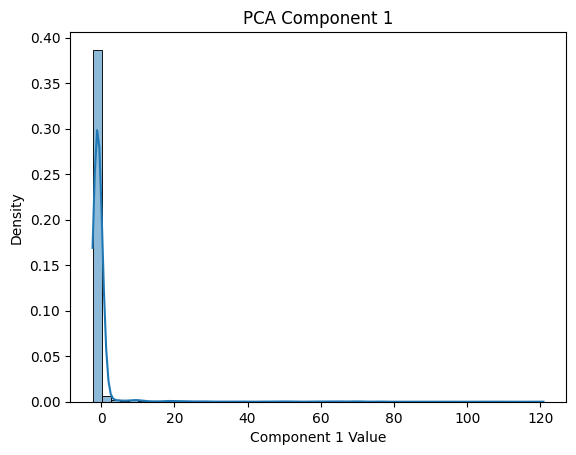

In [376]:
sns.histplot(component_1, kde=True, stat="density", bins=50, legend=None)
plt.xlabel('Component 1 Value')
plt.title('PCA Component 1')

<u>Factor Analysis</u>

A more robust version is known as factor analysis. It works well even if the random variables don't all have the same finite variance (known as heteroscedasticity).

We can see below that, despite the number, almost all the variation is explained by one component, as was the case with PCA.

In [24]:
def factor_analysis_explained(X_data, n_components):
    fa = FactorAnalysis(n_components=n_components)
    components = fa.fit_transform(X_data)
    fa_loadings = fa.components_.T
    total_var = X_data.var(axis=0).sum()
    var_exp = np.sum(fa_loadings**2, axis=0)
    prop_var_exp = var_exp/total_var

    return components, prop_var_exp

In [25]:
components, prop_var_exp = factor_analysis_explained(df.drop(columns=['time remaining', 'tilt erupt']), 100)
print(f'Variance explained by FA components: {prop_var_exp.round(3)}')
print(f'Cumulative proportion of variance explained by FA components: {np.cumsum(prop_var_exp).round(3)}')

Variance explained by FA components: [0.975 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]
Cumulative proportion of variance explained by FA components: [0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975
 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975
 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975
 0.975 0.975 0.975 0.975 0.975]


## Outliers

Code for creating box plots of features. I reuse this at least once.

In [26]:
def feature_box_plots(df, cols, title):
    rows = (df.shape[1] + (cols-1))//cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    for i, feature in enumerate(df.columns):
        sns.boxplot(df[feature], ax=axs[i//cols, i%cols])
        axs[i//cols, i%cols].set_title(feature)
        
    fig.suptitle(title)
    fig.tight_layout()

Get the uncorrelated data again for this section just so I'm consistent about what I'm dealing with. I use the condition index for feature selection.

In [ ]:
df = extract_manual_features(*convert_series_to_sequences(data_train_and_validate, seq_len=eda_seq_len, type='overlap'))
columns_to_drop, cond_idxs = uncorrelated_features(df, threshold=30, metric_function=condition_index_series)
df_uncorrelated = df.drop(columns=columns_to_drop)

In [28]:
df_uncorrelated

mean    median       min       max  25th percentile  time remaining  \
0    -9.54e-13  2.94e-12 -2.50e-10  3.14e-10        -7.09e-11             900   
1     7.21e-13  2.94e-12 -2.24e-10  3.14e-10        -7.09e-11             875   
2     2.30e-12  4.00e-12 -2.24e-10  3.14e-10        -6.83e-11             850   
3     1.02e-12  4.00e-12 -2.80e-10  3.14e-10        -7.13e-11             825   
4     2.30e-12  4.41e-12 -2.80e-10  3.14e-10        -7.13e-11             800   
...        ...       ...       ...       ...              ...             ...   
5888 -6.71e-11 -8.58e-11 -1.37e-09  1.36e-09        -4.42e-10             100   
5889 -6.67e-11 -8.78e-11 -1.37e-09  1.36e-09        -4.38e-10              75   
5890 -6.89e-11 -9.89e-11 -1.37e-09  1.36e-09        -4.42e-10              50   
5891 -3.87e-11 -7.40e-11 -1.37e-09  1.36e-09        -4.05e-10              25   
5892  1.89e-11 -3.02e-11 -1.37e-09  2.01e-09        -3.70e-10               0   

      tilt erupt  
0       8.82e-09  
1       8.82e-09  
2       8.82e-09  
3       8.82e-09  
4       8.82e-09  
...          ...  
5888    1.41e-09  
5889    1.41e-09  
5890    1.41e-09  
5891    1.41e-09  
5892    1.41e-09  

[5893 rows x 7 columns]

Check the description of the uncorrelated features (using condition index). Just by looking at this information, we can see that there is quite a lot of variation in most of the features.

In [29]:
df_uncorrelated.describe()

mean    median       min       max  25th percentile  \
count  5.89e+03  5.89e+03  5.89e+03  5.89e+03         5.89e+03   
mean  -5.24e-10 -4.83e-10 -1.97e-09  1.83e-09        -9.41e-10   
std    3.09e-09  3.07e-09  6.11e-09  1.71e-08         4.38e-09   
min   -3.67e-08 -3.74e-08 -6.42e-08 -2.54e-08        -4.71e-08   
25%   -1.64e-11 -1.90e-11 -1.42e-09  3.08e-10        -3.32e-10   
50%   -9.39e-13 -1.29e-12 -7.69e-10  7.08e-10        -1.79e-10   
75%    8.22e-12  1.05e-11 -3.54e-10  1.34e-09        -7.72e-11   
max    2.26e-09  2.55e-10 -1.98e-10  4.43e-07        -3.35e-11   

       time remaining  tilt erupt  
count         5893.00    5.89e+03  
mean           500.74    5.08e-08  
std            309.25    1.01e-07  
min              0.00    7.37e-10  
25%            250.00    2.82e-09  
50%            500.00    1.66e-08  
75%            750.00    4.29e-08  
max           1350.00    4.43e-07

There are clearly many statistical outliers in the data, as seen in the plots of uncorrelated features below. However, there is nothing wrong with these outliers, so there's no justification for removing them. However, that doesn't mean that they're not a problem. They can still affect the performance of the model. Therefore, I did a bit of research, and came across the PowerTransformer in scikit-learn. It tranforms the data to make it more Gaussian-like. I explore its effects more below.

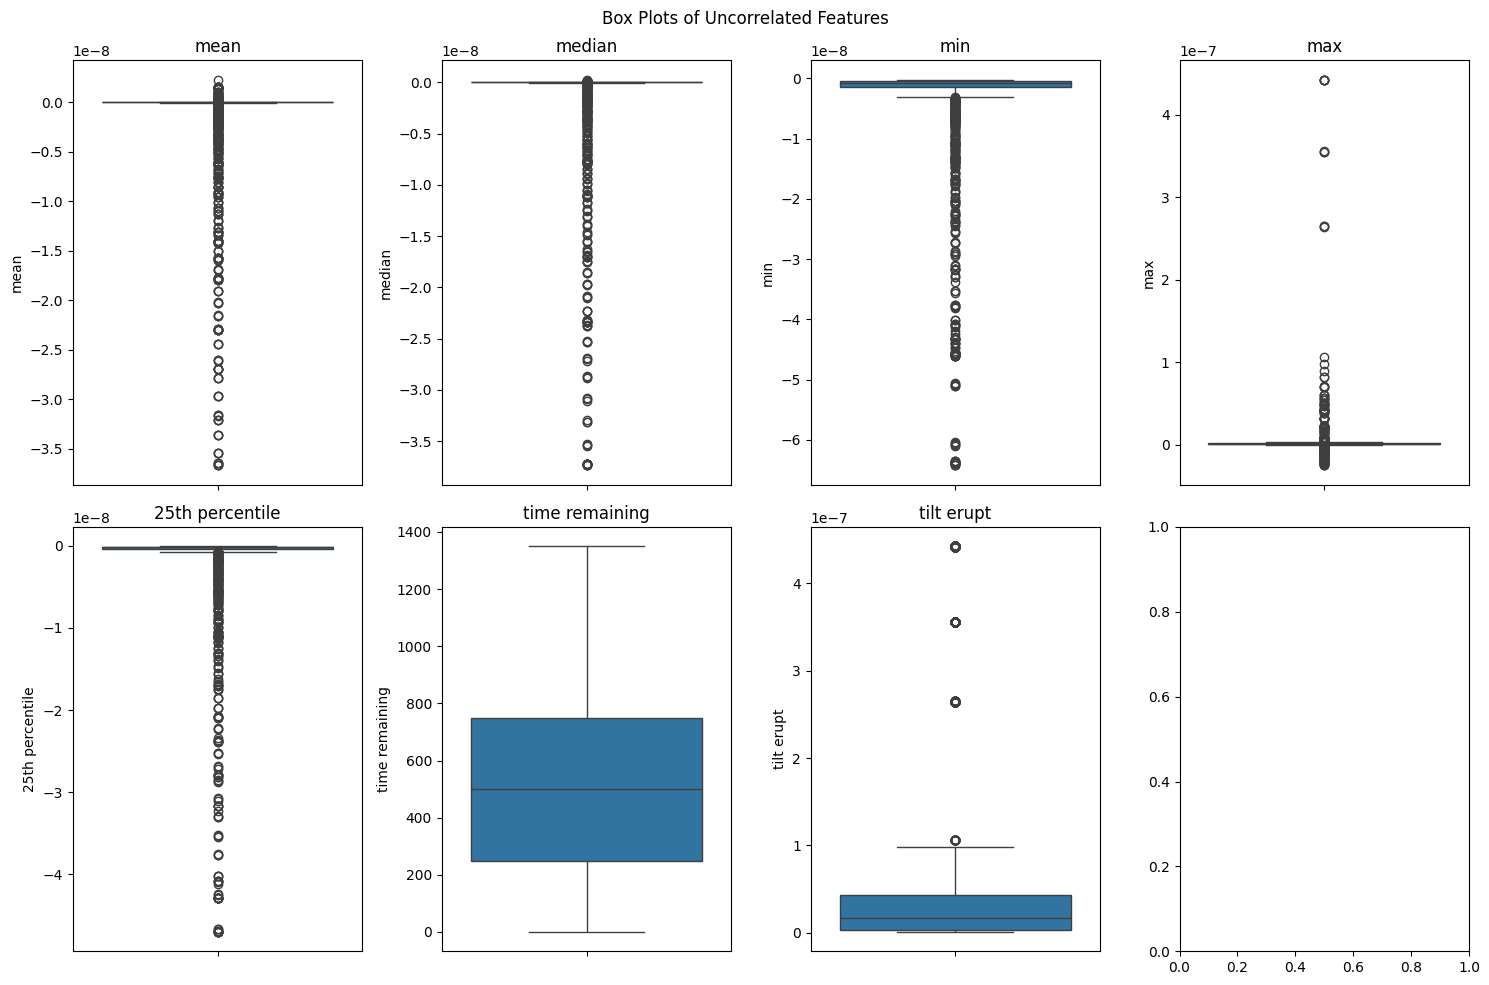

In [30]:
feature_box_plots(df_uncorrelated, cols=4, title='Box Plots of Uncorrelated Features')

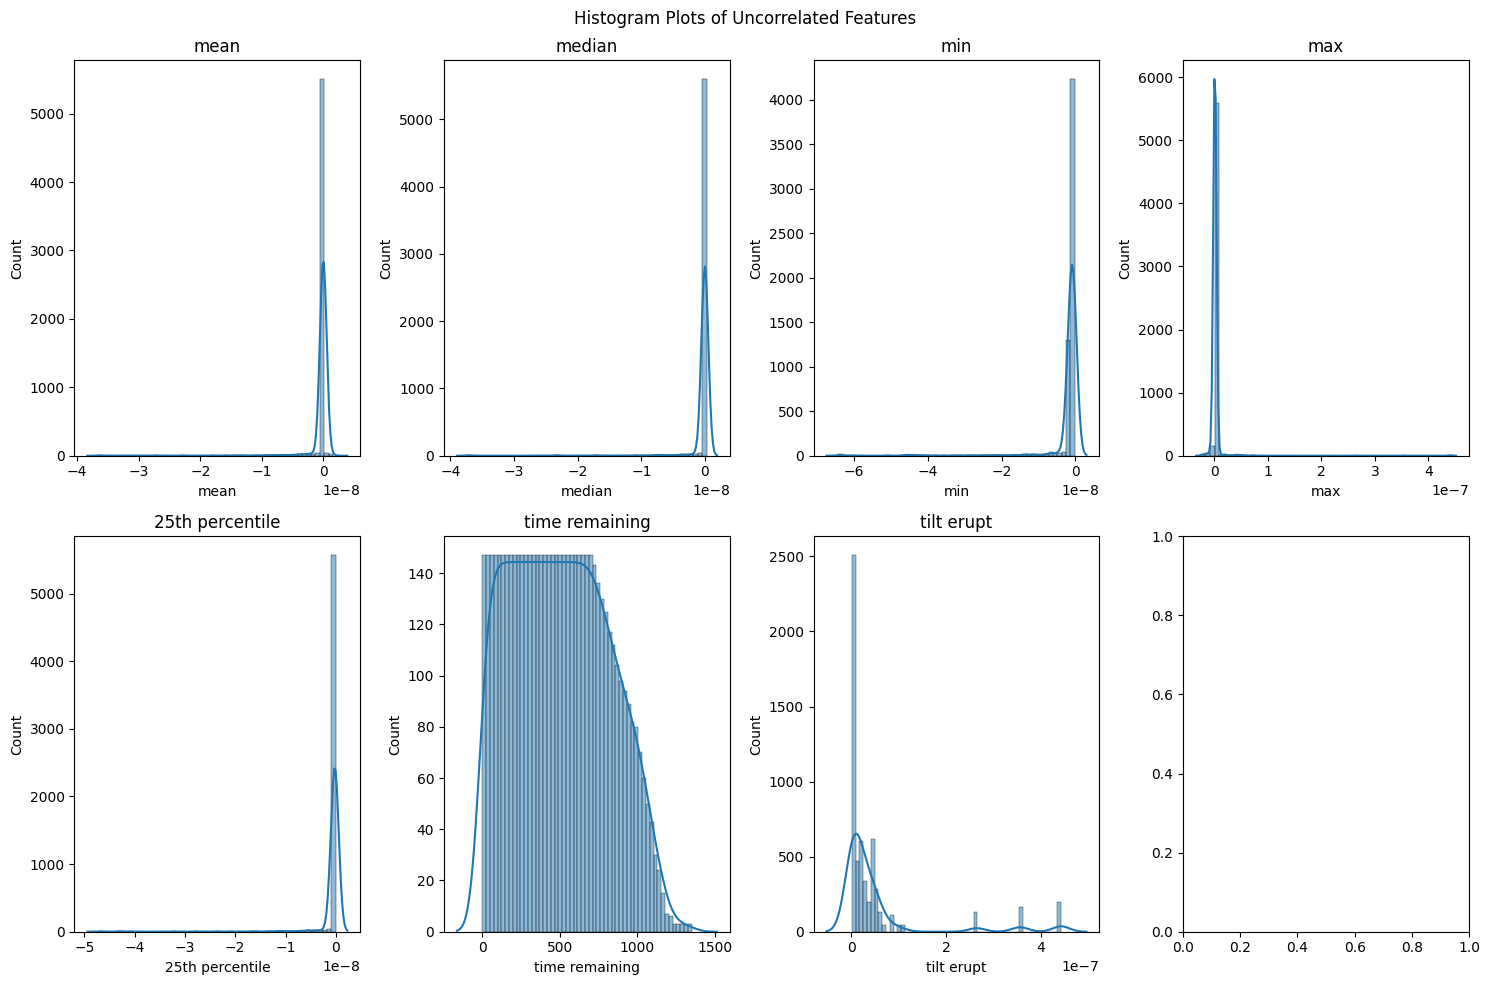

In [31]:
cols=4
rows = (df_uncorrelated.shape[1] + (cols-1))//cols
n_bins = int((max(df_uncorrelated['time remaining']) - min(df_uncorrelated['time remaining'])) / 25 + 1)

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
for i, feature in enumerate(df_uncorrelated.columns):
    sns.histplot(df_uncorrelated[feature], ax=axs[i//cols, i%cols], kde=True, kde_kws=dict(cut=3), bins=n_bins)
    axs[i//cols, i%cols].set_title(feature)
    
fig.suptitle('Histogram Plots of Uncorrelated Features')
fig.tight_layout()

We can see in the pair plots below that there are still some strong correlations in the data.

Text(0.5, 1.01, 'Pair Plots for Uncorrelated Features With Outliers')

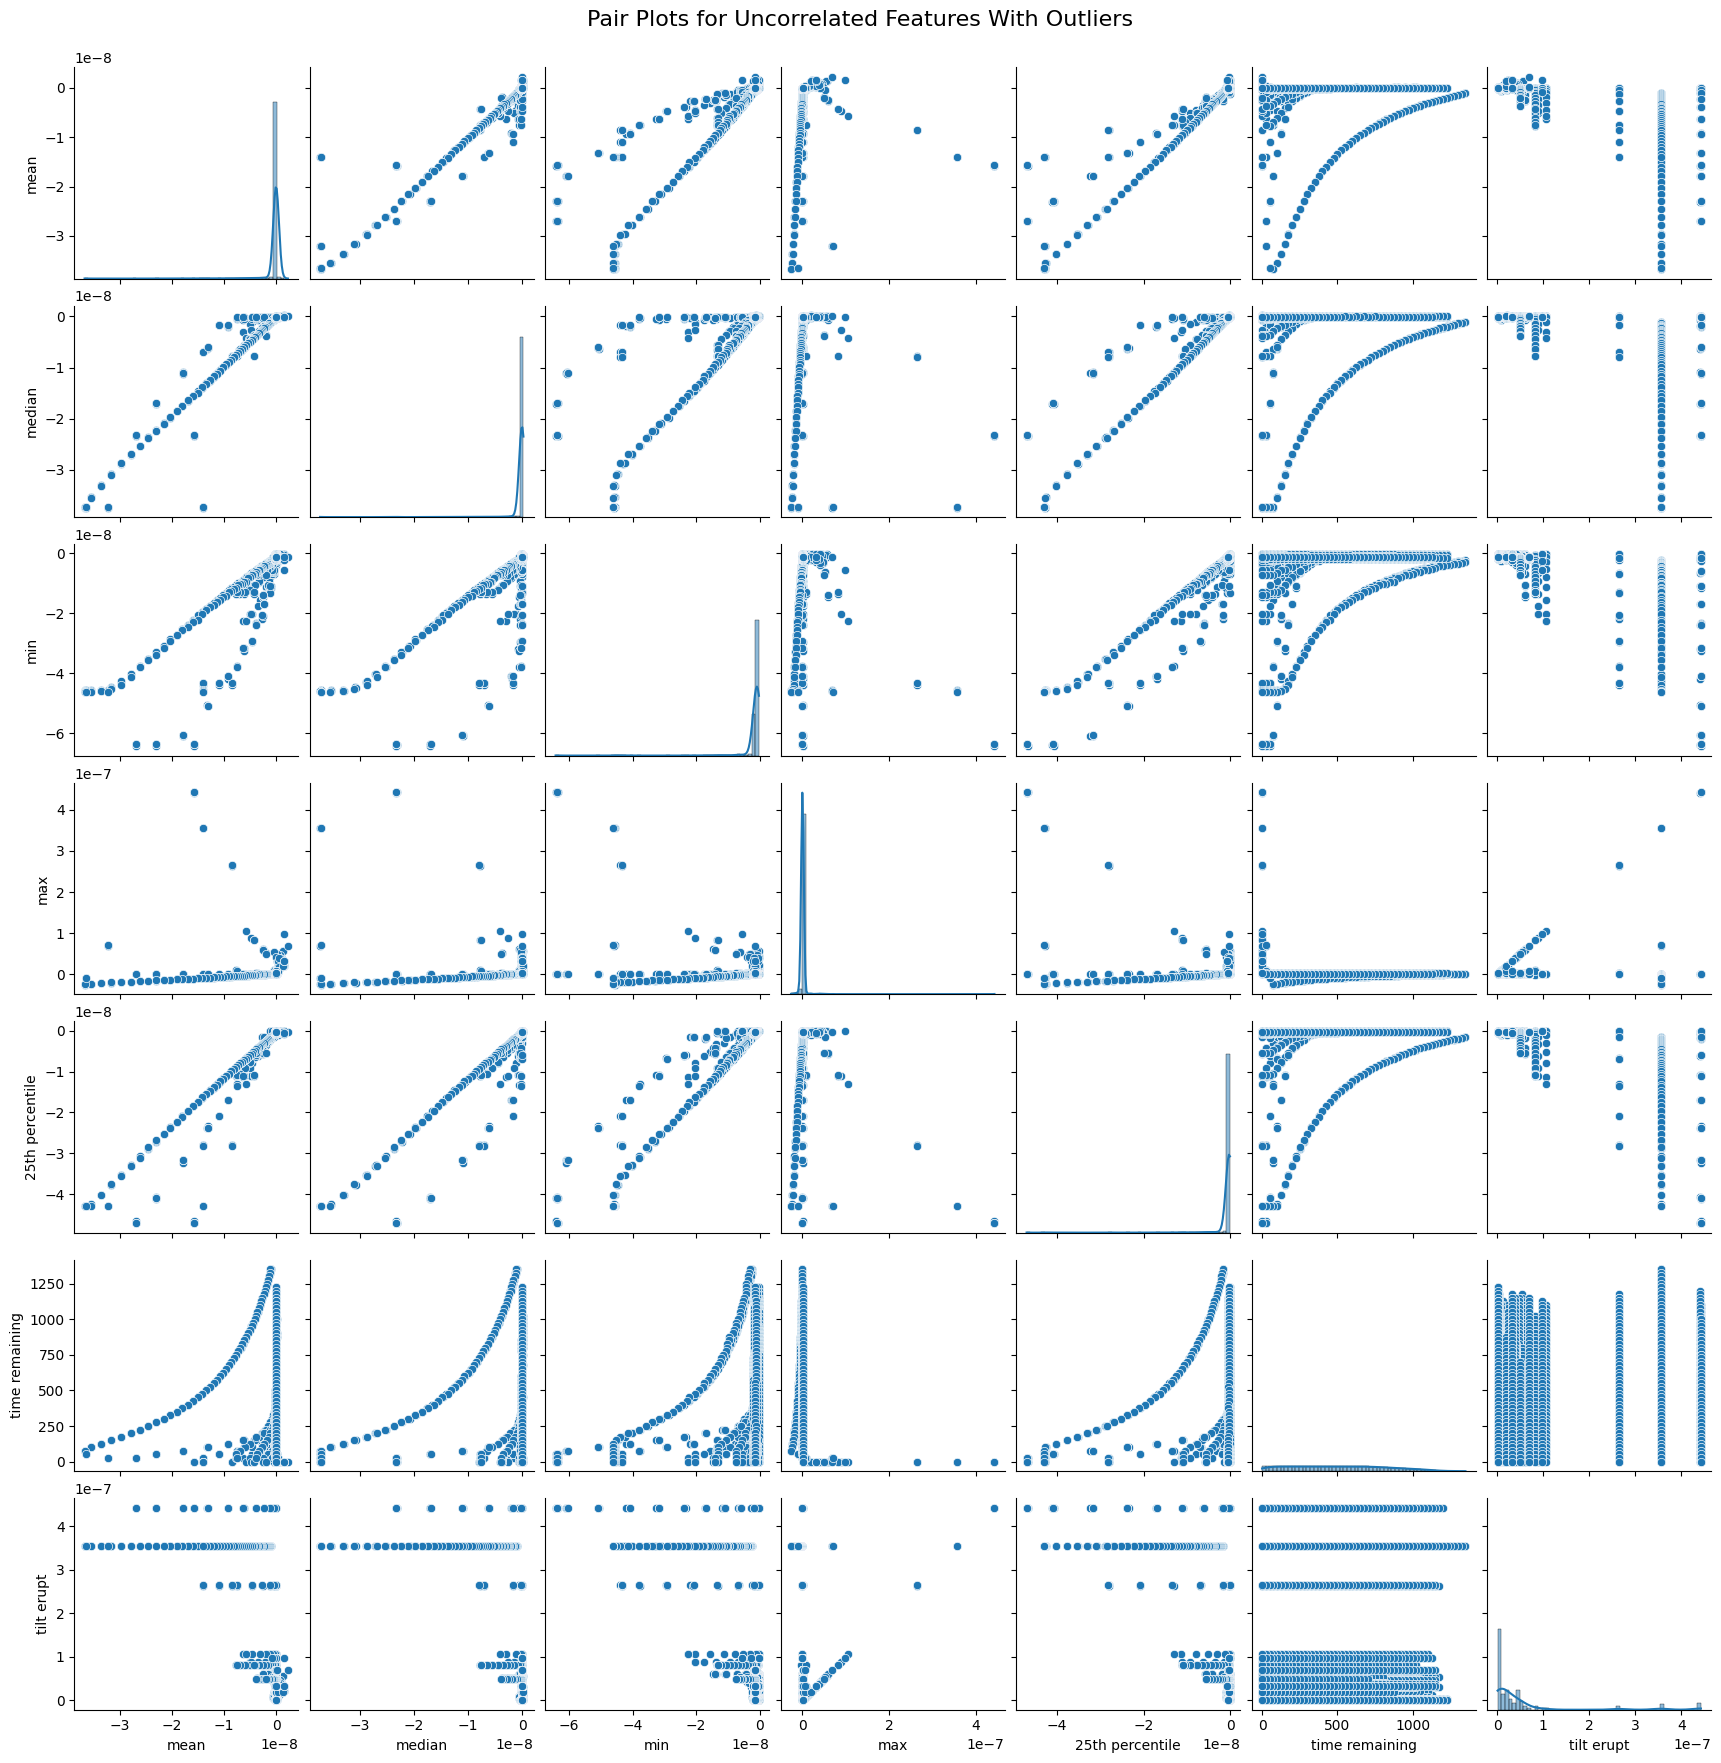

In [32]:
n_bins = int((max(df_uncorrelated['time remaining']) - min(df_uncorrelated['time remaining'])) / 25 + 1)
g = sns.pairplot(df_uncorrelated, diag_kws=dict(kde=True, bins=n_bins))
g.figure.suptitle('Pair Plots for Uncorrelated Features With Outliers', y=1.01, fontsize=16)

#### Option: Removing Outliers

Removing the statistical outliers (by the inter-quartile range metric) is an option. As we can see below, it reduces the number of data points from 5893 to 4843, which is perhaps tolerable. However, I have no justification for removing these outliers aside from the fact that they're outliers. They're valid data points, and would likely hurt the model's predicitive power.

We also have the option of just removing rows with outliers in the tilt erupt outcome, but given that we have no way to predict what will be an outlier there without training a model, the option is unviable.

In [33]:
def remove_outliers(df_in, drop_y_outliers=False, drop_only_y_outliers=False):
    y_cols = []
    if 'time remaining' in df_in.columns:
        y_cols.append('time remaining')
    if 'tilt erupt' in df_in.columns:
        y_cols.append('tilt erupt')
    
    if drop_only_y_outliers:
        df_outliers_calc = df_in[y_cols]
    elif drop_y_outliers:
        df_outliers_calc = df_in
    else:
        df_outliers_calc = df_in.drop(columns=y_cols)
      
    q1 = df_outliers_calc.quantile(0.25)
    q3 = df_outliers_calc.quantile(0.75)
    iqr = q3-q1
    if drop_only_y_outliers:
        not_outliers = df_outliers_calc[:][~((df_outliers_calc<(q1-1.5*iqr)) | (df_outliers_calc>(q3+1.5*iqr)))]
        not_outliers = pd.concat([df_in.drop(columns=y_cols), not_outliers], axis=1)
    elif drop_y_outliers:
        not_outliers = df_in[:][~((df_outliers_calc<(q1-1.5*iqr)) | (df_outliers_calc>(q3+1.5*iqr)))]
    else:
        not_outliers = df_in[df_outliers_calc.columns][~((df_outliers_calc<(q1-1.5*iqr)) | (df_outliers_calc>(q3+1.5*iqr)))]
        not_outliers = pd.concat([not_outliers, df_in[y_cols]], axis=1)
    df_no_outliers = not_outliers.dropna()
    
    return df_no_outliers

In [34]:
df_filtered1 = remove_outliers(df_uncorrelated)
print(f'Data points before removing outliers from uncorrelated data: {df_uncorrelated.shape[0]}')
print(f'Data points after removing outliers from uncorrelated data: {df_filtered1.shape[0]}')

Data points before removing outliers from uncorrelated data: 5893
Data points after removing outliers from uncorrelated data: 4843


Removing the outliers in just the independent features (not time remaining or tilt erupt) removes many outlying dots in the scatter plots. Many other feaures disappear as well. I postulate that the fact that the data groups into three clumps in many of the plots is related to the sigma parameter in the data file.

Text(0.5, 1.01, 'Pair Plots for Uncorrelated Features Without Outliers')

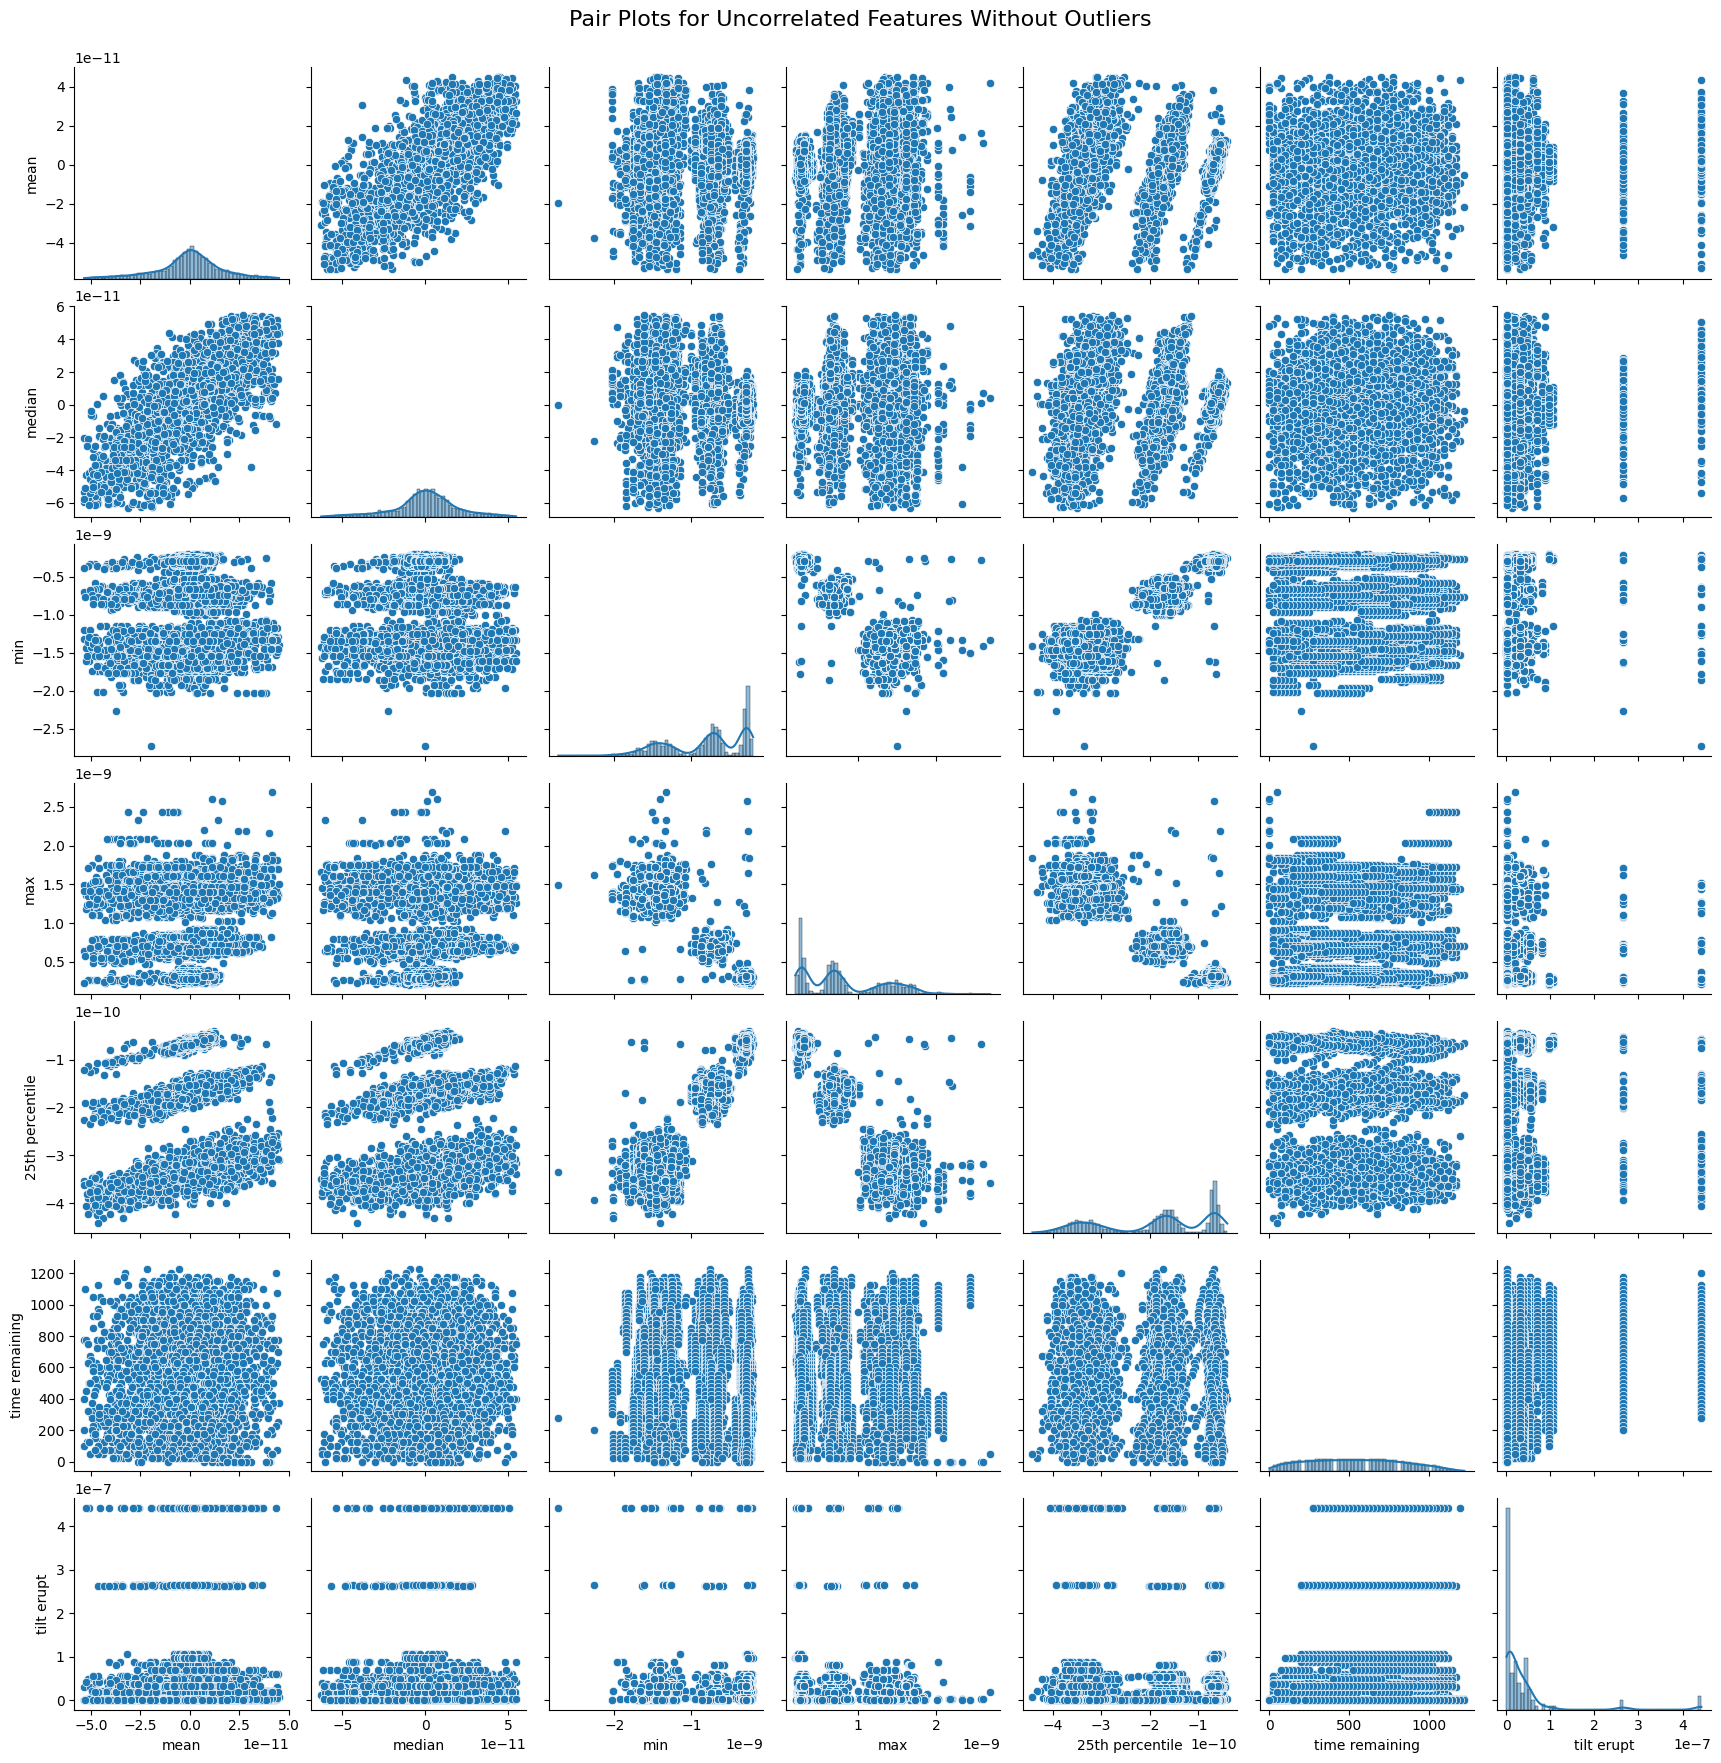

In [35]:
g = sns.pairplot(df_filtered1, diag_kws=dict(kde=True, bins=n_bins))
g.figure.suptitle('Pair Plots for Uncorrelated Features Without Outliers', y=1.01, fontsize=16)

#### Better Option: Power Transformer

Usually we use linear scalers in our machine learning tasks, but there are non-linear options. Scikit-Learn's PowerTransformer uses the Yeo-Johnson transform by default, which is a non-linear transformation that brings the outliers closer to the mean. We can see such an effect on the features in the two plots below. We also see peaks in the mean, median, and max shifted more towards the center of their ranges. I explore the effect of this transform on the modeling later on.

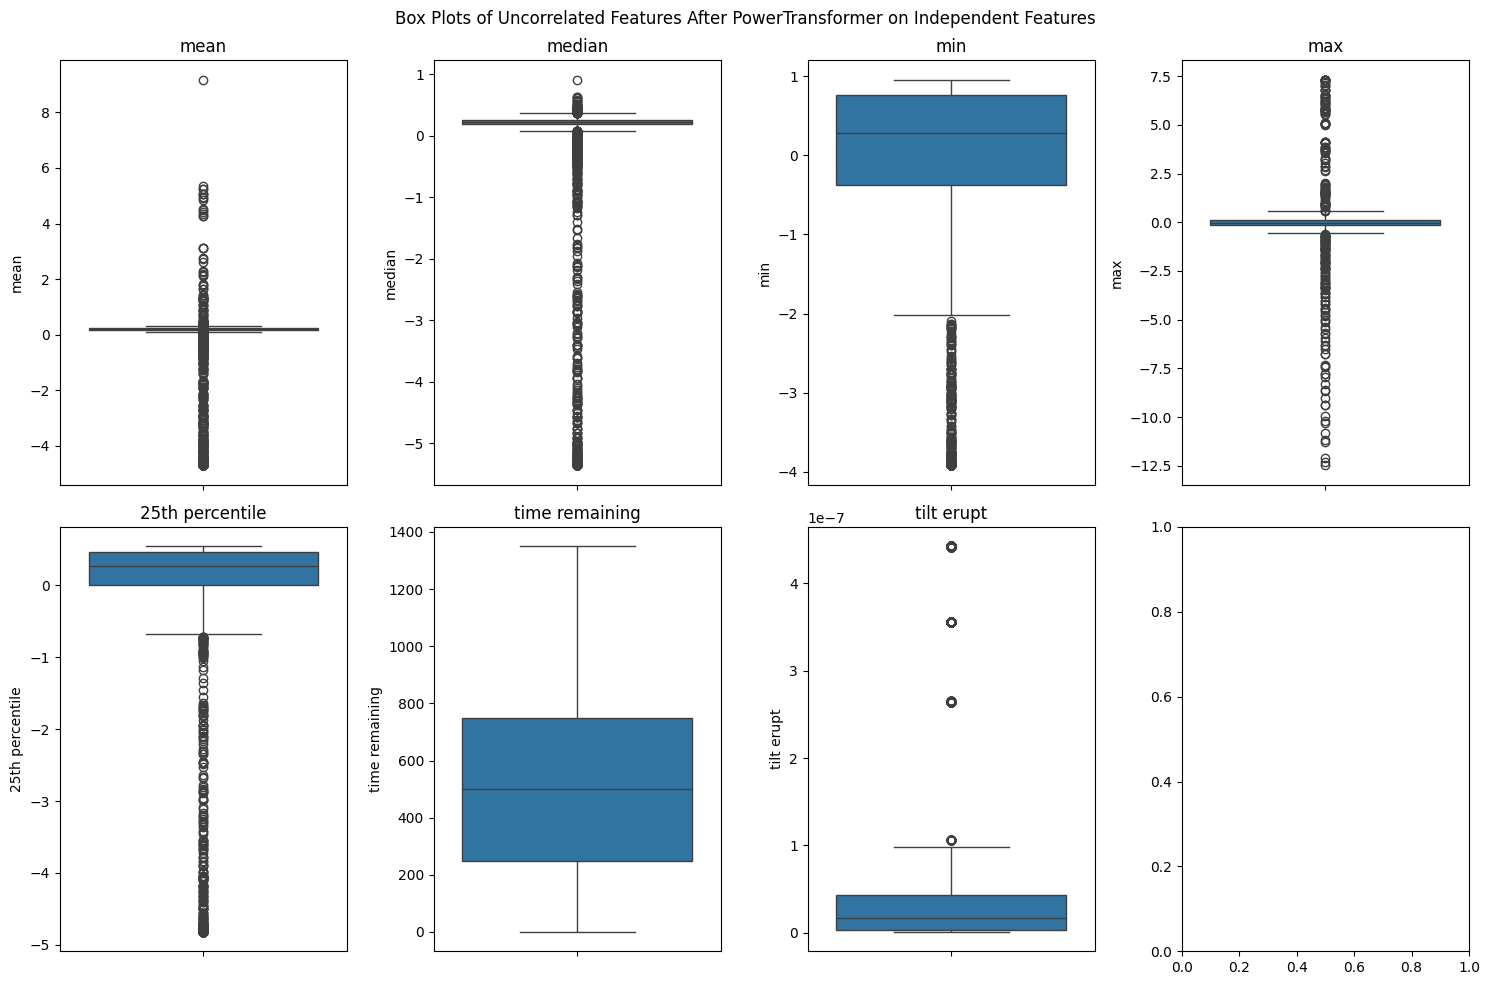

In [36]:
scaler = PowerTransformer()
X_train = df_uncorrelated.drop(columns=['time remaining', 'tilt erupt'])
X_transformed = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
df_tranformed = pd.concat([X_transformed, df_uncorrelated[['time remaining', 'tilt erupt']]], axis=1)
feature_box_plots(df_tranformed, cols=4, title='Box Plots of Uncorrelated Features After PowerTransformer on Independent Features')

Text(0.5, 1.01, 'Pair Plots of Uncorrelated Features After PowerTransformer on Independent Features')

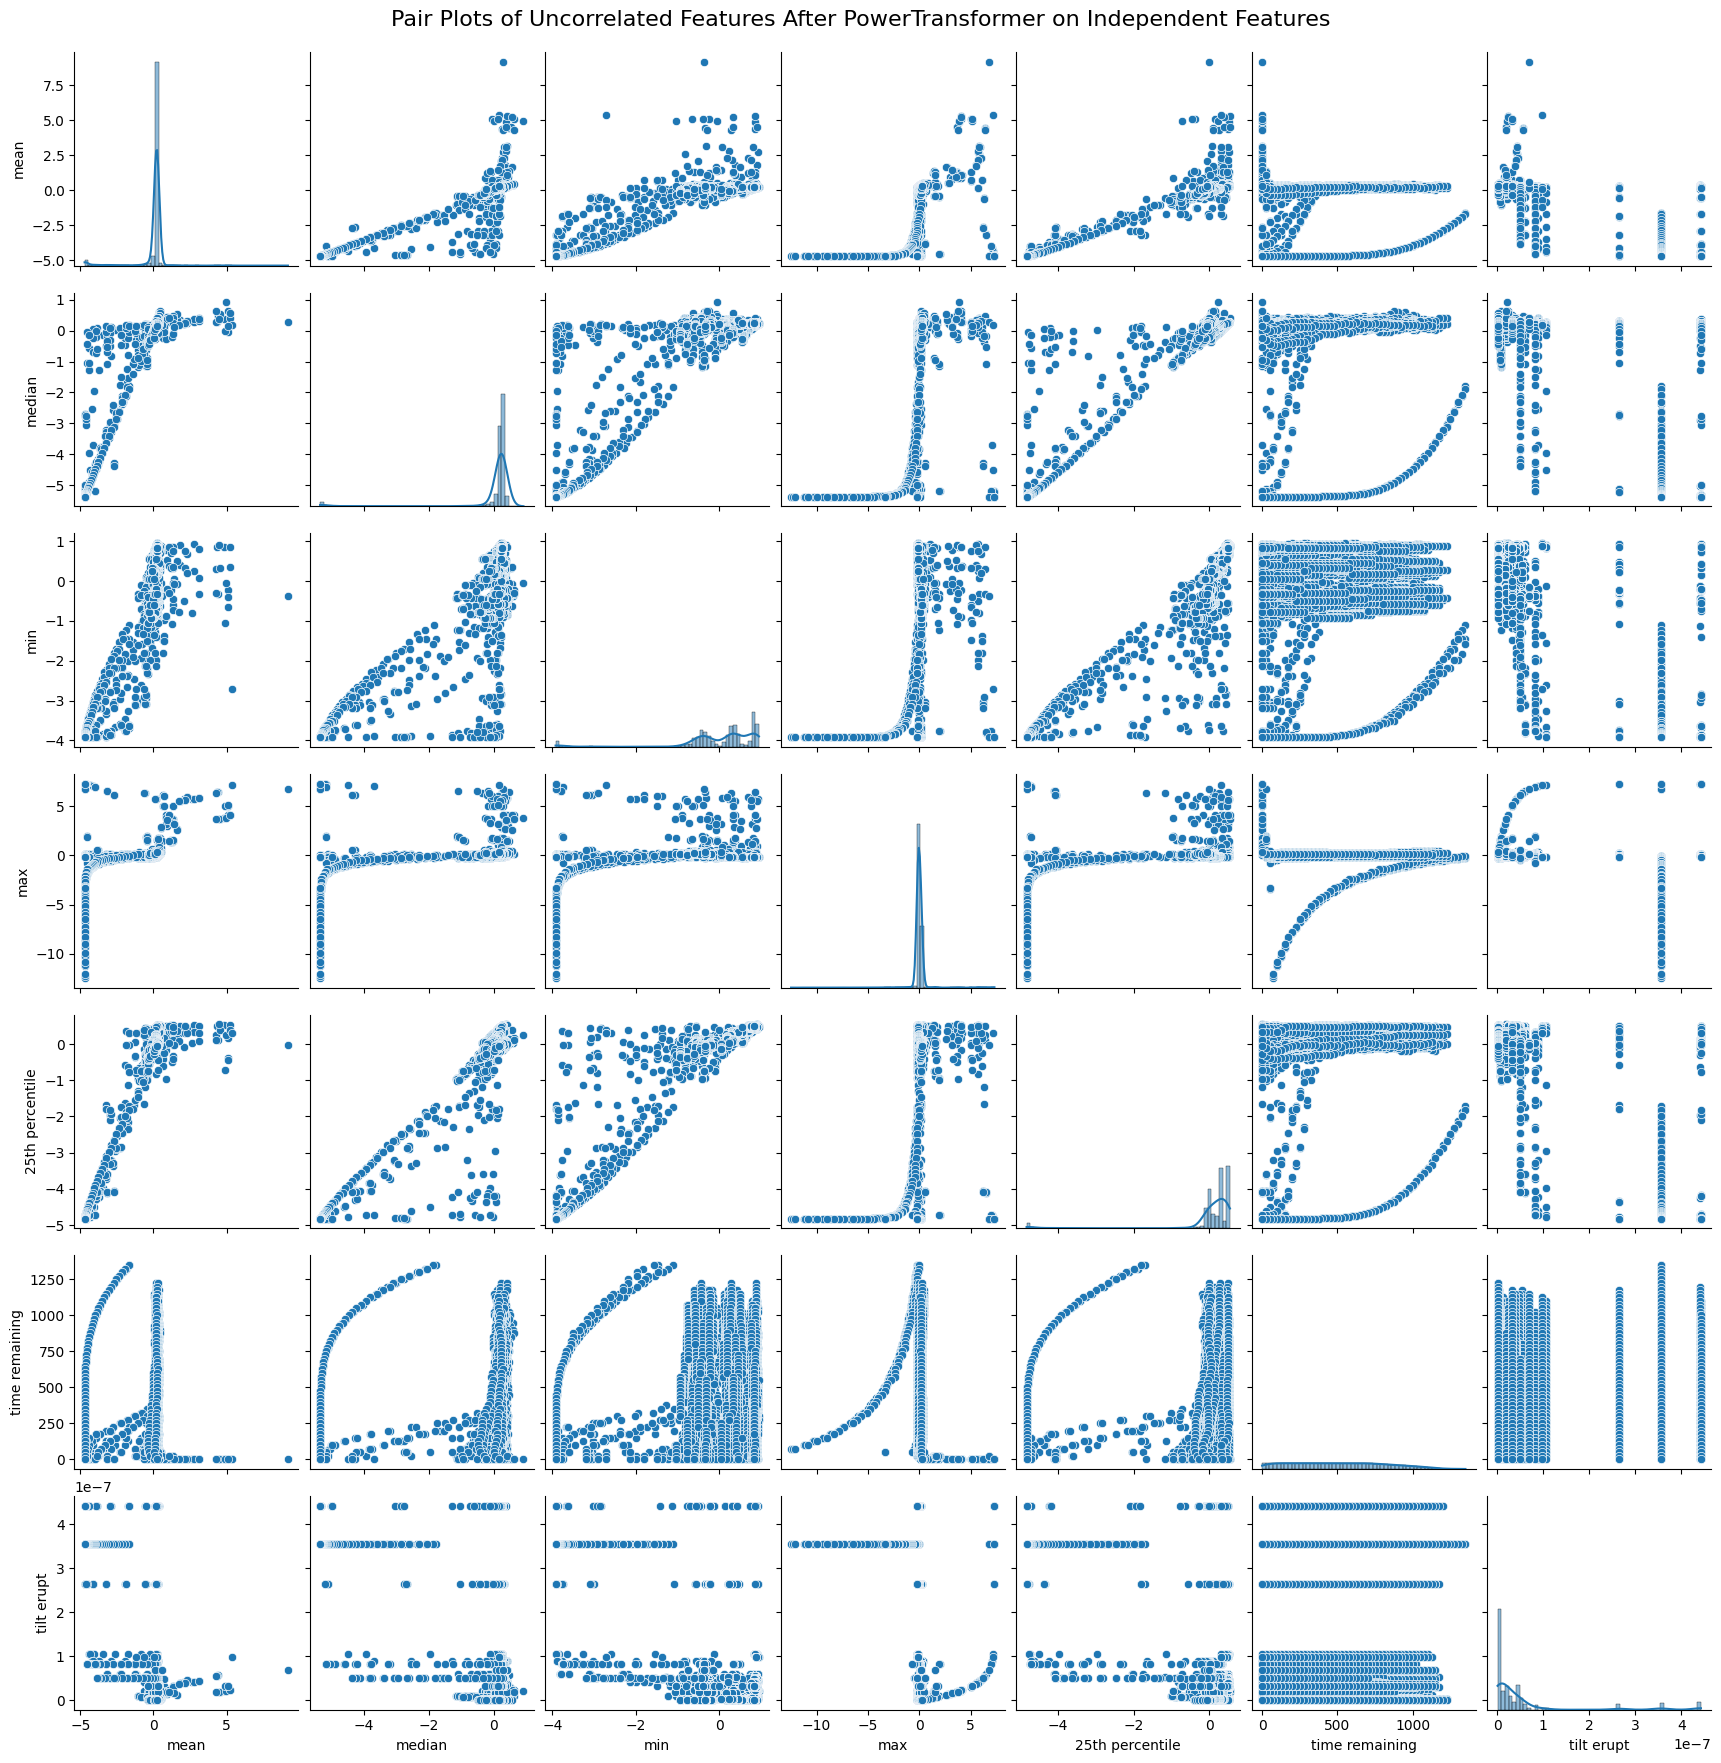

In [37]:
g = sns.pairplot(df_tranformed, diag_kws=dict(kde=True, bins=n_bins))
g.figure.suptitle('Pair Plots of Uncorrelated Features After PowerTransformer on Independent Features', y=1.01, fontsize=16)

## Model Testing: Use LazyPredict to test some feature engineering options

LazyPredict is a tool that trains and validates many models then returns the RMS error, R^2, and adjusted R^2 metrics about the fit on the validation data in a dataframe. It does not, however, scan hyperparameters. So it is just a test of how well models peform with their standard settings.

Note that LazyPredict does scale the independent features internally using the StandardScaler.

Setup a LazyPredict wrapper that optionally scales/transforms the data (and optionally y) and runs LazyPredict. We use this a lot, so it saves a lot of space.

In [108]:
def run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=PowerTransformer, transform_y=False):
    if scaler is not None:
        X_scaler = scaler()
        X_train_working = X_scaler.fit_transform(X_train)
        X_validate_working = X_scaler.transform(X_validate)
    else:
        X_train_working = X_train
        X_validate_working = X_validate
    
    if scaler is not None and transform_y:
        y_scaler = scaler()
        y_train_working = y_scaler.fit_transform(y_train)
        y_validate_working = y_scaler.transform(y_validate)
    else:
        y_train_working = y_train
        y_validate_working = y_validate
        
    def rmse_untransformed(y_true, y_pred):
        y_true_ = y_true.reshape(-1, 1) if y_true.ndim == 1 else y_true
        y_pred_ = y_pred.reshape(-1, 1) if y_pred.ndim == 1 else y_pred
        y_true_inv = y_scaler.inverse_transform(y_true_)
        y_pred_inv = y_scaler.inverse_transform(y_pred_)
        
        # error occurs if any NaNs
        if np.isnan(y_true_inv).any() or np.isnan(y_pred_inv).any():
            return float("inf")
        
        return root_mean_squared_error(y_true_inv, y_pred_inv)

    if scaler is not None and transform_y:
        regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=rmse_untransformed)
    else:
        regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
        
    return regressor.fit(X_train_working, X_validate_working, y_train_working, y_validate_working)

We need to determine the best sequence length to use, so I lay out which ones to test here. I could test longer sequence lengths, and it would improve some model results. However, I need to make a judgement call, and I choose a maximum sequence length of 300. Clearly, a sequence length of the entire observation sequence would produce a great result every time. However, it would also not produce a useful model. In practice (ignoring the fact that volcanologists don't directly measure pressure), we presumably have measurements coming in continuously, and run the model every few time-steps (or maybe every time-step if the model's fast enough) to update the predictions. The longer the required time sequence for prediction, the longer we have to gather data before running the model. Therefore, I need to balance the fact that longer sequences produce better evaluation metrics with the wait time to start running the model. Without a domain exert to contribute, I have to make that call myself, and I choose 300 as the longest sequence.

In [121]:
test_seq_lens = [50, 100, 150, 200, 250, 300]

### RMS Error Upper Bound by Predicting Mean

Set an upper bound on the root mean squared (RMS) error for our models by using the mean as the prediction (R^2 is by definition 0 for this prediction). I use the overlapped sequences for this calculation, but explore modeling the other options later with LazyPredict.

In [40]:
def RMSE_upper_bound(y_train, y_validate):
    return np.sqrt(np.sum((y_validate - np.mean(y_train))**2)/len(y_validate))

#### Time to eruption

In [ ]:
for seq_len in test_seq_lens:
    df_train = extract_manual_features(*convert_series_to_sequences(data_train, seq_len=seq_len, type='overlap'))
    df_validate = extract_manual_features(*convert_series_to_sequences(data_validate, seq_len=seq_len, type='overlap'))
    RMSE_time = RMSE_upper_bound(df_train['time remaining'], df_validate['time remaining'])
    print(f'seq_len: {seq_len}, upper bound RMSE time to erupt: {RMSE_time:.2f}')

seq_len: 50, upper bound RMSE time to erupt: 387.60
seq_len: 100, upper bound RMSE time to erupt: 373.83
seq_len: 150, upper bound RMSE time to erupt: 360.12
seq_len: 200, upper bound RMSE time to erupt: 346.46
seq_len: 250, upper bound RMSE time to erupt: 332.86
seq_len: 300, upper bound RMSE time to erupt: 319.33


#### Tilt erupt

In [ ]:
for seq_len in test_seq_lens:
    df_train = extract_manual_features(*convert_series_to_sequences(data_train, seq_len=seq_len, type='overlap'))
    df_validate = extract_manual_features(*convert_series_to_sequences(data_validate, seq_len=seq_len, type='overlap'))
    RMSE_tilt_erupt = RMSE_upper_bound(df_train['tilt erupt'], df_validate['tilt erupt'])
    print(f'seq_len: {seq_len}, upper bound RMSE tilt erupt: {RMSE_tilt_erupt:.2E}')

seq_len: 50, upper bound RMSE tilt erupt: 8.57E-08
seq_len: 100, upper bound RMSE tilt erupt: 8.57E-08
seq_len: 150, upper bound RMSE tilt erupt: 8.57E-08
seq_len: 200, upper bound RMSE tilt erupt: 8.57E-08
seq_len: 250, upper bound RMSE tilt erupt: 8.57E-08
seq_len: 300, upper bound RMSE tilt erupt: 8.57E-08


### Model Sequence Length Simulations With Manual Features Without Handling Multicollinearity
Simulations using manual feature extraction without handling multicollinearity or outliers. I use these to help determine which sequence extraction method and length work best for the time to eruption and the tilt erupt simulations.

In the end, my best option is to use overlapping sequences.

Automate looping over sequence lengths. The function `seq_len_models_loop` takes the best model from LazyPredict for each sequence and combines them into a dataframe that it displays.

In [ ]:
def format_scientific(df):
    if df.iloc[0]['RMSE'] < 1e-4:
        df['RMSE'] = df['RMSE'].apply(lambda x: '{:.2e}'.format(x))
        
    if 'rmse_untransformed' in df.columns and df.iloc[0]['rmse_untransformed'] < 1e-4:
        df['rmse_untransformed'] = df['rmse_untransformed'].apply(lambda x: '{:.2e}'.format(x))
    
    return df

def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

def seq_len_models_loop(lengths: list, data_train: list, data_validate: list, extract_type_train: str, extract_type_validate: str,
                        y_feature: str, scaler = None, transform_y: bool = False):
    best_models = []
    for seq_len in lengths:
        df_train = df_function(data_train, seq_len, extract_type_train, random_seed=5)
        df_validate = df_function(data_validate, seq_len, extract_type_validate, random_seed=6)
        X_train = df_train.drop(columns=['time remaining', 'tilt erupt'])
        X_validate = df_validate.drop(columns=['time remaining', 'tilt erupt'])
        y_train = df_train[y_feature].to_frame()
        y_validate = df_validate[y_feature].to_frame()
        models_time0, predictions_time0 = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=scaler, transform_y=transform_y)
        top_model = models_time0.loc[models_time0['R-Squared'].idxmax()]
        top_model['Sequence Length'] = seq_len
        best_models.append(top_model.to_frame().T)

    best_models_frame = pd.concat(best_models)
    best_models_frame['Sequence Length'] = best_models_frame['Sequence Length'].astype('int32')
    best_models_frame.index.name = 'Model'
    best_models_frame.reset_index(inplace=True)
    best_models_frame.set_index('Sequence Length', inplace=True)
    
    if 'rmse_untransformed' in best_models_frame.columns: 
        best_id_rmse = best_models_frame['rmse_untransformed'].idxmin()
    else:
        best_id_rmse = best_models_frame['RMSE'].idxmin()
    
    print('\n\nBest models by sequence length:')
    display(best_models_frame)
    
    best_model_rmse = best_models_frame.loc[best_id_rmse].to_frame().T.rename_axis('Sequence Length')
    best_model_rmse = format_scientific(best_model_rmse)
    print('Best option by RMS error:')
    display(best_model_rmse)
        
    return

#### Overlapping Training and Validation Sequences
I consider this a good option from a theoretical standpoint, as it exposes the model to a lot of evenly-spaced samples from each observation during training.

In this case, the best result, for both time remaining and tilt erupt, is a sequence lenght of 300 without transforming X and y.

To save time and space, after this subsection, I won't transform X and y.

##### Time to Eruption

The best option is a sequence length of 300 without transforming X and y.

No transforming both X and y:

In [378]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 16
[LightGBM] [Info] Start training from score 617.323770


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 21
[LightGBM] [Info] Start training from score 592.709364


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 26
[LightGBM] [Info] Start training from score 568.128746


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 31
[LightGBM] [Info] Start training from score 543.586557


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 36
[LightGBM] [Info] Start training from score 519.088335


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 494.640733


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.09       0.10   
100                      AdaBoostRegressor                0.11       0.12   
150                      AdaBoostRegressor                0.12       0.13   
200                      AdaBoostRegressor                0.14       0.15   
250                      AdaBoostRegressor                0.15       0.16   
300                      AdaBoostRegressor                0.16       0.18   

                   RMSE  Time Taken  
Sequence Length                      
50               367.65        2.47  
100              350.21        0.31  
150              334.76        0.34  
200              318.75        0.56  
250              303.61        0.76  
300              289.23        0.88

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
300              AdaBoostRegressor               0.16      0.18  289.23   

                Time Taken  
Sequence Length             
300                   0.88

Transform X but not y:

In [379]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='time remaining', scaler=PowerTransformer, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 16
[LightGBM] [Info] Start training from score 617.323770


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4973
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 21
[LightGBM] [Info] Start training from score 592.709364


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6205
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 26
[LightGBM] [Info] Start training from score 568.128746


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7458
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 31
[LightGBM] [Info] Start training from score 543.586557


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8725
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 36
[LightGBM] [Info] Start training from score 519.088335


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9987
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 494.640733


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.09       0.10   
100                      AdaBoostRegressor                0.10       0.11   
150                           MLPRegressor                0.10       0.11   
200                      AdaBoostRegressor                0.13       0.14   
250                      AdaBoostRegressor                0.14       0.16   
300                      AdaBoostRegressor                0.15       0.17   

                   RMSE  Time Taken  
Sequence Length                      
50               367.54        2.57  
100              352.96        0.26  
150              338.67        2.20  
200              320.72        0.44  
250              304.64        0.65  
300              290.14        0.53

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
300              AdaBoostRegressor               0.15      0.17  290.14   

                Time Taken  
Sequence Length             
300                   0.53

Transforming both X and y:

In [380]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='time remaining', scaler=PowerTransformer, transform_y=True)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4973
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 21
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6205
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7458
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8725
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 36
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9987
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.16       0.16   
100                           MLPRegressor                0.20       0.20   
150                           MLPRegressor                0.20       0.21   
200                                  NuSVR                0.20       0.21   
250                                    SVR                0.20       0.21   
300                                    SVR                0.20       0.22   

                 RMSE  Time Taken  rmse_untransformed  
Sequence Length                                        
50               0.94        2.15              371.32  
100              0.91        1.73              349.39  
150              0.91        1.82              336.09  
200              0.91        0.90              322.47  
250              0.91        1.13              308.57  
300              0.91        0.95              295.27

Best option by RMS error:


Model Adjusted R-Squared R-Squared  RMSE Time Taken  \
Sequence Length                                                       
300               SVR                0.2      0.22  0.91       0.95   

                rmse_untransformed  
Sequence Length                     
300                         295.27

##### Tilt Erupt

The best option is again a sequence length of 300 without transforming X and y.

No transforming both X and y:

In [381]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.35       0.35   
100              GradientBoostingRegressor                0.39       0.39   
150                    ExtraTreesRegressor                0.44       0.44   
200                    ExtraTreesRegressor                0.47       0.48   
250                    ExtraTreesRegressor                0.49       0.50   
300                    ExtraTreesRegressor                0.51       0.52   

                     RMSE  Time Taken  
Sequence Length                        
50               6.80e-08        2.30  
100              6.57e-08        2.90  
150              6.30e-08        1.26  
200              6.08e-08        1.36  
250              5.95e-08        1.48  
300              5.84e-08        1.52

Best option by RMS error:


Model Adjusted R-Squared R-Squared      RMSE  \
Sequence Length                                                               
300              ExtraTreesRegressor               0.51      0.52  5.84e-08   

                Time Taken  
Sequence Length             
300                   1.52

Transforming X but not y:

In [382]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='tilt erupt', scaler=PowerTransformer, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4973
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6205
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7458
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8725
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9987
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.35       0.35   
100              GradientBoostingRegressor                0.39       0.40   
150                    ExtraTreesRegressor                0.43       0.43   
200                    ExtraTreesRegressor                0.47       0.48   
250                    ExtraTreesRegressor                0.47       0.49   
300                    ExtraTreesRegressor                0.50       0.51   

                     RMSE  Time Taken  
Sequence Length                        
50               6.79e-08        2.11  
100              6.56e-08        2.59  
150              6.35e-08        1.18  
200              6.07e-08        1.29  
250              6.05e-08        1.44  
300              5.87e-08        1.49

Best option by RMS error:


Model Adjusted R-Squared R-Squared      RMSE  \
Sequence Length                                                               
300              ExtraTreesRegressor                0.5      0.51  5.87e-08   

                Time Taken  
Sequence Length             
300                   1.49

Transforming both X and y:

In [383]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='tilt erupt', scaler=PowerTransformer, transform_y=True)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 16
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4973
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 21
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6205
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 26
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7458
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 31
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8725
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9987
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score -0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  RMSE  Time Taken  \
Sequence Length                                                           
50               NuSVR                0.20       0.21  0.84        1.01   
100              NuSVR                0.22       0.23  0.83        0.86   
150              NuSVR                0.23       0.24  0.82        0.88   
200              NuSVR                0.24       0.25  0.81        0.89   
250              NuSVR                0.25       0.26  0.81        0.70   
300              NuSVR                0.25       0.27  0.80        0.74   

                 rmse_untransformed  
Sequence Length                      
50                         7.65e-08  
100                        7.55e-08  
150                        7.52e-08  
200                        7.45e-08  
250                        7.40e-08  
300                        7.33e-08

Best option by RMS error:


Model Adjusted R-Squared R-Squared RMSE Time Taken  \
Sequence Length                                                       
300              NuSVR               0.25      0.27  0.8       0.74   

                rmse_untransformed  
Sequence Length                     
300                       7.33e-08

#### Sequential Training Sequences, Overlapping Validation Sequences
I do not consider sequential sequences to be a good option. The sequences are extracted at set positions that can be far apart, resulting in just a few discrete training values for the time to eruption. Therefore, tree models may not produce good results when trained on sequential sequences and validated against data that does not match those discrete training values.

We can see the worse performance in the result, where RMS error increases from 289 to 299 for the time remaining and from 5.84e-08 to 6.66e-08 for the tilt erupt.

##### Time to Eruption

In [384]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='overlap', y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 16
[LightGBM] [Info] Start training from score 612.021037


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 21
[LightGBM] [Info] Start training from score 576.376147


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 26
[LightGBM] [Info] Start training from score 535.182999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6514
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 31
[LightGBM] [Info] Start training from score 504.292528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5893
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 36
[LightGBM] [Info] Start training from score 461.224490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5375
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 41
[LightGBM] [Info] Start training from score 416.326531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Model  Adjusted R-Squared  R-Squared    RMSE  \
Sequence Length                                                               
50                 AdaBoostRegressor                0.08       0.08  370.33   
100                AdaBoostRegressor                0.07       0.08  357.28   
150              ExtraTreesRegressor                0.09       0.10  340.70   
200              ExtraTreesRegressor                0.09       0.10  327.77   
250              ExtraTreesRegressor                0.09       0.10  314.34   
300              ExtraTreesRegressor                0.10       0.12  299.25   

                 Time Taken  
Sequence Length              
50                     0.12  
100                    0.09  
150                    0.37  
200                    0.29  
250                    0.23  
300                    0.19

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                             
300              ExtraTreesRegressor                0.1      0.12  299.25   

                Time Taken  
Sequence Length             
300                   0.19

##### Tilt Erupt

In [385]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='overlap', y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6514
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5893
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5375
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.35       0.35   
100                    ExtraTreesRegressor                0.33       0.34   
150                    ExtraTreesRegressor                0.31       0.32   
200                    ExtraTreesRegressor                0.36       0.37   
250                         HuberRegressor                0.36       0.38   
300                           ElasticNetCV                0.31       0.32   

                     RMSE  Time Taken  
Sequence Length                        
50               6.79e-08        1.11  
100              6.88e-08        0.32  
150              6.98e-08        0.24  
200              6.69e-08        0.21  
250              6.66e-08        0.05  
300              6.93e-08        0.09

Best option by RMS error:


Model Adjusted R-Squared R-Squared      RMSE  \
Sequence Length                                                          
250              HuberRegressor               0.36      0.38  6.66e-08   

                Time Taken  
Sequence Length             
250                   0.05

#### Sequential Training and Validation Sequences
I run these options together to illustrate the problem with using sequential sequences. The effect of using sequential sequences for both training and validation is large. The RMS error for time remaining drops from 289 to 227, indicating a serious problem.

##### Time to Eruption

In [386]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='sequential', y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 16
[LightGBM] [Info] Start training from score 612.021037


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 21
[LightGBM] [Info] Start training from score 576.376147


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 26
[LightGBM] [Info] Start training from score 535.182999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6514
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 31
[LightGBM] [Info] Start training from score 504.292528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5893
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 36
[LightGBM] [Info] Start training from score 461.224490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5375
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 41
[LightGBM] [Info] Start training from score 416.326531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Model  Adjusted R-Squared  R-Squared    RMSE  \
Sequence Length                                                               
50                 AdaBoostRegressor                0.11       0.12  366.13   
100              ExtraTreesRegressor                0.15       0.18  344.02   
150                AdaBoostRegressor                0.20       0.27  321.02   
200              ExtraTreesRegressor                0.29       0.38  291.09   
250              ExtraTreesRegressor                0.34       0.46  255.98   
300              ExtraTreesRegressor                0.38       0.54  227.44   

                 Time Taken  
Sequence Length              
50                     0.11  
100                    0.54  
150                    0.12  
200                    0.28  
250                    0.22  
300                    0.19

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                             
300              ExtraTreesRegressor               0.38      0.54  227.44   

                Time Taken  
Sequence Length             
300                   0.19

##### Tilt Erupt

In [387]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='sequential', y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6514
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5893
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5375
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.37       0.38   
100                    ExtraTreesRegressor                0.35       0.38   
150                    ExtraTreesRegressor                0.33       0.38   
200                    ExtraTreesRegressor                0.44       0.51   
250                    ExtraTreesRegressor                0.42       0.53   
300                          BayesianRidge                0.25       0.45   

                     RMSE  Time Taken  
Sequence Length                        
50               6.70e-08        1.21  
100              6.66e-08        0.32  
150              6.82e-08        0.25  
200              5.97e-08        0.21  
250              5.85e-08        0.18  
300              6.30e-08        0.01

Best option by RMS error:


Model Adjusted R-Squared R-Squared      RMSE  \
Sequence Length                                                               
250              ExtraTreesRegressor               0.42      0.53  5.85e-08   

                Time Taken  
Sequence Length             
250                   0.18

#### Random Training Sequences, Overlapping Validation Sequences
I consider random training sequences to be a decent option, but not the best. It balances providing a good spread of training values for the time to eruption with a decent run-time. The RMS error for the time to eruption only budges from 289 to 290 and for the tilt erup from 5.84e-8 to 5.99e-8. It will be a good option if I can't use overlapping training sequences.

##### Time to Eruption

In [388]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='overlap', y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 16
[LightGBM] [Info] Start training from score 629.992609


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 21
[LightGBM] [Info] Start training from score 612.140798


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 26
[LightGBM] [Info] Start training from score 579.637842


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 31
[LightGBM] [Info] Start training from score 554.125277


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 36
[LightGBM] [Info] Start training from score 528.125647


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 41
[LightGBM] [Info] Start training from score 500.541390


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.09       0.09   
100                      AdaBoostRegressor                0.11       0.12   
150                      AdaBoostRegressor                0.12       0.14   
200                      AdaBoostRegressor                0.11       0.13   
250                      AdaBoostRegressor                0.12       0.13   
300                      AdaBoostRegressor                0.15       0.17   

                   RMSE  Time Taken  
Sequence Length                      
50               368.28        1.16  
100              350.40        0.20  
150              334.23        0.30  
200              322.70        0.16  
250              308.95        0.29  
300              290.44        0.36

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
300              AdaBoostRegressor               0.15      0.17  290.44   

                Time Taken  
Sequence Length             
300                   0.36

##### Tilt Erupt

In [389]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='overlap', y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.31       0.31   
100                    ExtraTreesRegressor                0.33       0.34   
150                    ExtraTreesRegressor                0.41       0.42   
200                    ExtraTreesRegressor                0.44       0.45   
250                    ExtraTreesRegressor                0.47       0.48   
300                    ExtraTreesRegressor                0.48       0.50   

                     RMSE  Time Taken  
Sequence Length                        
50               6.99e-08        1.14  
100              6.87e-08        0.72  
150              6.44e-08        0.79  
200              6.26e-08        0.89  
250              6.08e-08        0.85  
300              5.99e-08        0.93

Best option by RMS error:


Model Adjusted R-Squared R-Squared      RMSE  \
Sequence Length                                                               
300              ExtraTreesRegressor               0.48       0.5  5.99e-08   

                Time Taken  
Sequence Length             
300                   0.93

#### Random Training and Validation Sequences
I run this option to see if it has much impact on the validation scores. With random validation sequences, the RMS error for time to eruption increases to 297 but drops to 5.89e-8 for the tilt erupt.

##### Time to Eruption

In [390]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='random', y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 16
[LightGBM] [Info] Start training from score 629.992609


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 21
[LightGBM] [Info] Start training from score 612.140798


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 26
[LightGBM] [Info] Start training from score 579.637842


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 31
[LightGBM] [Info] Start training from score 554.125277


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 36
[LightGBM] [Info] Start training from score 528.125647


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 41
[LightGBM] [Info] Start training from score 500.541390


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.07       0.08   
100                      AdaBoostRegressor                0.09       0.11   
150                      AdaBoostRegressor                0.08       0.10   
200                      AdaBoostRegressor                0.09       0.11   
250                    ExtraTreesRegressor                0.09       0.12   
300                      AdaBoostRegressor                0.09       0.13   

                   RMSE  Time Taken  
Sequence Length                      
50               368.25        1.12  
100              353.26        0.21  
150              340.79        0.30  
200              323.00        0.18  
250              310.60        1.87  
300              296.99        0.34

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
300              AdaBoostRegressor               0.09      0.13  296.99   

                Time Taken  
Sequence Length             
300                   0.34

##### Tilt Erupt

In [391]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='random', y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.29       0.30   
100              GradientBoostingRegressor                0.50       0.51   
150                    ExtraTreesRegressor                0.45       0.46   
200                    ExtraTreesRegressor                0.43       0.45   
250                    ExtraTreesRegressor                0.46       0.48   
300                    ExtraTreesRegressor                0.47       0.49   

                     RMSE  Time Taken  
Sequence Length                        
50               7.02e-08        1.13  
100              5.89e-08        1.52  
150              6.19e-08        0.70  
200              6.24e-08        0.76  
250              6.10e-08        0.84  
300              6.03e-08        0.92

Best option by RMS error:


Model Adjusted R-Squared R-Squared  \
Sequence Length                                                           
100              GradientBoostingRegressor                0.5      0.51   

                     RMSE Time Taken  
Sequence Length                       
100              5.89e-08       1.52

#### Final Selections
These are used below in further feature engineering and the final modeling.

In [138]:
time_seq_len = 300
tilt_erupt_seq_len = 300
time_extract_type_train = 'overlap'
time_extract_type_validate = 'overlap'
tilt_erupt_extract_type_train = 'overlap'
tilt_erupt_extract_type_validate = 'overlap'


### Model Sequence Length Simulations With Manual Features and Handling Multicollinearity
Simulations using manual feature extraction and handling multicollinearity. I use the condition index to remove multicollinearity. I use these to help determine which sequence extraction method and length work best for the time to eruption and the tilt erupt simulations.

In the end, my best option is to stick with not removing multicollinearity.

Automate looping over sequence lengths

In [392]:
def format_scientific(df):
    if df.iloc[0]['RMSE'] < 1e-4:
        df['RMSE'] = df['RMSE'].apply(lambda x: '{:.2e}'.format(x))
        
    if 'rmse_untransformed' in df.columns and df.iloc[0]['rmse_untransformed'] < 1e-4:
        df['rmse_untransformed'] = df['rmse_untransformed'].apply(lambda x: '{:.2e}'.format(x))
    
    return df

def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

def seq_len_models_loop(lengths: list, data_train: list, data_validate: list, extract_type: str,
                        multicollinearity_metric_function: Callable, multicollinearity_threshold: int, y_feature: str, scaler = None, transform_y: bool = False):  
    best_models = []
    for seq_len in lengths:
        df_train = df_function(data_train, seq_len, extract_type, random_seed=5)
        df_validate = df_function(data_validate, seq_len, extract_type, random_seed=6)
        X_train = df_train.drop(columns=['time remaining', 'tilt erupt'])
        X_validate = df_validate.drop(columns=['time remaining', 'tilt erupt'])
        y_train = df_train[y_feature].to_frame()
        y_validate = df_validate[y_feature].to_frame()
        if multicollinearity_metric_function is not None:
            ci_columns_to_drop, cond_idxs = uncorrelated_features(X_train, threshold=multicollinearity_threshold, metric_function=multicollinearity_metric_function)
            X_train = X_train.drop(columns=ci_columns_to_drop)
            X_validate = X_validate.drop(columns=ci_columns_to_drop)
        models_time0, predictions_time0 = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=scaler, transform_y=transform_y)
        top_model = models_time0.loc[models_time0['R-Squared'].idxmax()]
        top_model['Sequence Length'] = seq_len
        best_models.append(top_model.to_frame().T)

    best_models_frame = pd.concat(best_models)
    best_models_frame['Sequence Length'] = best_models_frame['Sequence Length'].astype('int32')
    best_models_frame.index.name = 'Model'
    best_models_frame.reset_index(inplace=True)
    best_models_frame.set_index('Sequence Length', inplace=True)
    
    if 'rmse_untransformed' in best_models_frame.columns: 
        best_id_rmse = best_models_frame['rmse_untransformed'].idxmin()
    else:
        best_id_rmse = best_models_frame['RMSE'].idxmin()
    
    print('\n\nBest models by sequence length:')
    display(best_models_frame)
        
    best_model_rmse = best_models_frame.loc[best_id_rmse].to_frame().T.rename_axis('Sequence Length')
    best_model_rmse = format_scientific(best_model_rmse)
    print('Best option by RMS error:')
    display(best_model_rmse)
        
    return

#### Overlapping Training and Validation Sequences
The uncorrelated features don't perform any better than the features with multicollinearity. The best RMS error for time remaining is 297 with transformed X and y vs 289 previously with no transformations, and the best RMS error for the tilt erupt is 6.04e-08	with transformed X vs 5.84e-8 previously with no transformations.

##### Time to Eruption

No transforming both X and y:

In [393]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='overlap', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 2
[LightGBM] [Info] Start training from score 617.323770


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 4
[LightGBM] [Info] Start training from score 592.709364


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 4
[LightGBM] [Info] Start training from score 568.128746


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 4
[LightGBM] [Info] Start training from score 543.586557


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 5
[LightGBM] [Info] Start training from score 519.088335


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 6
[LightGBM] [Info] Start training from score 494.640733


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.09       0.10   
100              GradientBoostingRegressor                0.09       0.10   
150                      AdaBoostRegressor                0.09       0.09   
200                      AdaBoostRegressor                0.08       0.08   
250                      AdaBoostRegressor                0.08       0.08   
300                      AdaBoostRegressor                0.07       0.07   

                   RMSE  Time Taken  
Sequence Length                      
50               368.04        0.40  
100              354.75        0.62  
150              342.50        0.08  
200              330.85        0.10  
250              318.51        0.12  
300              306.50        0.08

Best option by RMS error:


Model Adjusted R-Squared R-Squared   RMSE  \
Sequence Length                                                          
300              AdaBoostRegressor               0.07      0.07  306.5   

                Time Taken  
Sequence Length             
300                   0.08

Transforming X but not y:

In [394]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='overlap', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='time remaining', scaler=PowerTransformer, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 2
[LightGBM] [Info] Start training from score 617.323770


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 4
[LightGBM] [Info] Start training from score 592.709364


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 4
[LightGBM] [Info] Start training from score 568.128746


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 4
[LightGBM] [Info] Start training from score 543.586557


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 5
[LightGBM] [Info] Start training from score 519.088335


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 6
[LightGBM] [Info] Start training from score 494.640733


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.09       0.10   
100              GradientBoostingRegressor                0.09       0.10   
150                      AdaBoostRegressor                0.09       0.09   
200                      AdaBoostRegressor                0.09       0.09   
250                      AdaBoostRegressor                0.10       0.10   
300                           MLPRegressor                0.08       0.08   

                   RMSE  Time Taken  
Sequence Length                      
50               368.04        0.39  
100              354.75        0.64  
150              343.15        0.10  
200              330.10        0.08  
250              314.48        0.15  
300              305.61        1.40

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE Time Taken
Sequence Length                                                              
300              MLPRegressor               0.08      0.08  305.61        1.4

Transforming both X and y:

In [395]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='overlap', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='time remaining', scaler=PowerTransformer, transform_y=True)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 2
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 4
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 5
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 6
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.15       0.15   
100              GradientBoostingRegressor                0.15       0.15   
150                                    SVR                0.15       0.15   
200                                    SVR                0.16       0.16   
250                                    SVR                0.19       0.19   
300                                    SVR                0.20       0.20   

                 RMSE  Time Taken  rmse_untransformed  
Sequence Length                                        
50               0.94        0.37              372.07  
100              0.94        0.59              358.51  
150              0.94        0.79              344.16  
200              0.94        0.71              329.64  
250              0.92        0.67              311.30  
300              0.92        0.66              297.17

Best option by RMS error:


Model Adjusted R-Squared R-Squared  RMSE Time Taken  \
Sequence Length                                                       
300               SVR                0.2       0.2  0.92       0.66   

                rmse_untransformed  
Sequence Length                     
300                         297.17

For the Time to Eruption, the best option is a sequence length of 300 and transforming of X and/or y makes little difference, so we'll see what happens with the tilt erupt and keep the transformations consistent between both.

##### Tilt Erupt

No transforming both X and y:

In [396]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='overlap', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 2
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 5
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 6
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                                 
50                   GradientBoostingRegressor                0.40       0.40   
100                  GradientBoostingRegressor                0.36       0.37   
150                          AdaBoostRegressor                0.42       0.42   
200              HistGradientBoostingRegressor                0.34       0.34   
250                        ExtraTreesRegressor                0.39       0.39   
300                  GradientBoostingRegressor                0.45       0.45   

                     RMSE  Time Taken  
Sequence Length                        
50               6.52e-08        0.39  
100              6.73e-08        0.59  
150              6.41e-08        0.06  
200              6.87e-08        0.29  
250              6.59e-08        0.32  
300              6.25e-08        0.66

Best option by RMS error:


Model Adjusted R-Squared R-Squared  \
Sequence Length                                                           
300              GradientBoostingRegressor               0.45      0.45   

                     RMSE Time Taken  
Sequence Length                       
300              6.25e-08       0.66

Transforming X but not y:

In [397]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='overlap', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='tilt erupt', scaler=PowerTransformer, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 2
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 5
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 6
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.40       0.40   
100              OrthogonalMatchingPursuit                0.39       0.39   
150                         HuberRegressor                0.44       0.44   
200                         HuberRegressor                0.45       0.45   
250                         HuberRegressor                0.47       0.47   
300                         HuberRegressor                0.49       0.49   

                     RMSE  Time Taken  
Sequence Length                        
50               6.53e-08    4.08e-01  
100              6.60e-08    7.80e-03  
150              6.32e-08    4.92e-02  
200              6.25e-08    5.16e-02  
250              6.13e-08    6.07e-02  
300              6.04e-08    5.13e-02

Best option by RMS error:


Model Adjusted R-Squared R-Squared      RMSE  \
Sequence Length                                                          
300              HuberRegressor               0.49      0.49  6.04e-08   

                Time Taken  
Sequence Length             
300                   0.05

Transforming both X and y:

In [398]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='overlap', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='tilt erupt', scaler=PowerTransformer, transform_y=True)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 2
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 4
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4839, number of used features: 4
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4627, number of used features: 4
[LightGBM] [Info] Start training from score -0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4415, number of used features: 5
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 6
[LightGBM] [Info] Start training from score -0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  RMSE  Time Taken  \
Sequence Length                                                           
50                 SVR                0.22       0.22  0.83        0.95   
100              NuSVR                0.21       0.22  0.83        0.68   
150              NuSVR                0.22       0.22  0.83        0.62   
200              NuSVR                0.23       0.23  0.83        0.63   
250              NuSVR                0.24       0.24  0.82        0.53   
300              NuSVR                0.25       0.25  0.81        0.50   

                 rmse_untransformed  
Sequence Length                      
50                         6.96e-08  
100                        7.61e-08  
150                        7.56e-08  
200                        7.50e-08  
250                        7.41e-08  
300                        7.32e-08

Best option by RMS error:


Model Adjusted R-Squared R-Squared  RMSE Time Taken  \
Sequence Length                                                       
50                SVR               0.22      0.22  0.83       0.95   

                rmse_untransformed  
Sequence Length                     
50                        6.96e-08

For the Tilt Erupt, the best option is a sequence length of 300, with transforming X making little difference and transforming y hurting the result.

Moving forward, I will transform neither X nor y.

#### Sequential Training and Validation Sequences

This option outperforms for the time remaining again. Note that the number of features differes compared to the overlapping sequences, as seen in the LightGBM info.

##### Time to Eruption

In [181]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='sequential', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 3
[LightGBM] [Info] Start training from score 612.021037


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 4
[LightGBM] [Info] Start training from score 576.376147


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 4
[LightGBM] [Info] Start training from score 535.182999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 4
[LightGBM] [Info] Start training from score 504.292528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 4
[LightGBM] [Info] Start training from score 461.224490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 3
[LightGBM] [Info] Start training from score 416.326531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.14       0.14   
100              GradientBoostingRegressor                0.18       0.19   
150                      AdaBoostRegressor                0.22       0.23   
200                      AdaBoostRegressor                0.26       0.27   
250                      AdaBoostRegressor                0.40       0.41   
300                      AdaBoostRegressor                0.46       0.47   

                   RMSE  Time Taken  
Sequence Length                      
50               361.80        0.28  
100              343.03        0.20  
150              328.39        0.04  
200              314.20        0.03  
250              268.14        0.04  
300              245.11        0.05

Best option by adjusted R^2 metric:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
300              AdaBoostRegressor               0.46      0.47  245.11   

                Time Taken  
Sequence Length             
300                   0.05

##### Tilt Erupt

In [182]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='sequential', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 3
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1308, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 3
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.40       0.40   
100                      AdaBoostRegressor                0.40       0.41   
150              GradientBoostingRegressor                0.38       0.39   
200              GradientBoostingRegressor                0.44       0.45   
250                  RandomForestRegressor                0.45       0.46   
300              GradientBoostingRegressor                0.50       0.51   

                     RMSE  Time Taken  
Sequence Length                        
50               6.56e-08        0.28  
100              6.49e-08        0.02  
150              6.75e-08        0.13  
200              6.37e-08        0.13  
250              6.26e-08        0.16  
300              6.00e-08        0.06

Best option by adjusted R^2 metric:


Model Adjusted R-Squared R-Squared  \
Sequence Length                                                           
300              GradientBoostingRegressor                0.5      0.51   

                     RMSE Time Taken  
Sequence Length                       
300              6.00e-08       0.06

Using sequential sequences produces a worse result than using overlapping sequences.

#### Random Training and Validation Sequences
This option performs worse than the overlapping sequences. Note that the number of features again differs compared to with the overlapping sequences, as can be seen in the LightGBM info.

##### Time to Eruption

In [183]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='random', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 2
[LightGBM] [Info] Start training from score 629.992609


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 3
[LightGBM] [Info] Start training from score 612.140798


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 3
[LightGBM] [Info] Start training from score 579.637842


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 2
[LightGBM] [Info] Start training from score 554.125277


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 3
[LightGBM] [Info] Start training from score 528.125647


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 4
[LightGBM] [Info] Start training from score 500.541390


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.07       0.07   
100                      AdaBoostRegressor                0.09       0.09   
150                      AdaBoostRegressor                0.07       0.07   
200              GradientBoostingRegressor                0.09       0.10   
250                      AdaBoostRegressor                0.11       0.11   
300                      AdaBoostRegressor                0.08       0.08   

                   RMSE  Time Taken  
Sequence Length                      
50               369.66        0.18  
100              356.65        0.05  
150              346.38        0.04  
200              325.91        0.19  
250              312.38        0.04  
300              304.26        0.05

Best option by adjusted R^2 metric:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
250              AdaBoostRegressor               0.11      0.11  312.38   

                Time Taken  
Sequence Length             
250                   0.04

Best option by RMS error:


Model Adjusted R-Squared R-Squared    RMSE  \
Sequence Length                                                           
300              AdaBoostRegressor               0.08      0.08  304.26   

                Time Taken  
Sequence Length             
300                   0.05

##### Tilt Erupt

In [184]:
seq_len_models_loop(test_seq_lens, data_train=data_train, data_validate=data_validate, extract_type='random', multicollinearity_metric_function=condition_index_series,
                    multicollinearity_threshold=30, y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 2
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 3
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 3
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 2
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 3
[LightGBM] [Info] Start training from score 0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


Best models by sequence length:


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50                       AdaBoostRegressor                0.33       0.33   
100              GradientBoostingRegressor                0.47       0.47   
150                                RidgeCV                0.38       0.38   
200                      AdaBoostRegressor                0.43       0.43   
250              GradientBoostingRegressor                0.44       0.44   
300                    ExtraTreesRegressor                0.41       0.41   

                     RMSE  Time Taken  
Sequence Length                        
50               6.88e-08    2.52e-02  
100              6.13e-08    2.58e-01  
150              6.63e-08    6.39e-03  
200              6.36e-08    2.02e-02  
250              6.29e-08    2.58e-01  
300              6.47e-08    1.93e-01

Best option by adjusted R^2 metric:


Model Adjusted R-Squared R-Squared  \
Sequence Length                                                           
100              GradientBoostingRegressor               0.47      0.47   

                     RMSE Time Taken  
Sequence Length                       
100              6.13e-08       0.26

## TSFresh
TSFresh is a tool that extracts features from time-sequence data. It comes up with hundreds of features, many of which are probably useless to us and many of which are probably correlated.

We have to extract features for the time to eruption and the tilt erupt separately, as TSFresh comes up with separate features for them.

I don't test different sequence lengths here because TSFresh produces a lot of features and I'm using overlapping sequences with a sequence length of 300, which will make the models take a long time to train.

In [404]:
pressure_train, y_time_train, y_tilt_erupt_train = convert_series_to_sequences(data_train, seq_len=time_seq_len, type=time_extract_type_train)
pressure_validate, y_time_validate, y_tilt_erupt_validate = convert_series_to_sequences(data_validate, seq_len=time_seq_len, type=time_extract_type_validate)
pressure_test, y_time_test, y_tilt_erupt_test = convert_series_to_sequences(data_test, seq_len=time_seq_len, type=time_extract_type_validate)

### Tests on features without modification

The TSFresh features did worse than the manual features at predicting the time remaining (RMS error of 293 vs 289) but better at predicting the tilt erupt (RMS error of 5.71e-8 vs 5.84e-8). I will move forward with using the manual features for now and only consider the TSFresh features for predicting the tilt erupt if necessary.

##### Time to eruption

Note that the adjusted R^2 is a lot worse than R^2, implying that there are a lot of irrelevant features despite TSFresh attempting to only provide relevant ones.

In [400]:
X_tsfresh_time_train = extract_relevant_features(pressure_train, y_time_train, column_id='sequence id', column_sort='time', ml_task='regression')
X_tsfresh_time_validate = extract_features(pressure_validate, column_id='sequence id', column_sort='time')
X_tsfresh_time_validate = X_tsfresh_time_validate[X_tsfresh_time_train.columns]
models, predictions = run_lazypredict(X_tsfresh_time_train, X_tsfresh_time_validate, y_time_train, y_time_validate, scaler=None, transform_y=False)
models

Feature Extraction: 100%|██████████| 40/40 [00:44<00:00,  1.10s/it]


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78964
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 346
[LightGBM] [Info] Start training from score 494.640733


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
AdaBoostRegressor                       -6.44e-02   1.54e-01  2.93e+02   
GradientBoostingRegressor               -8.02e-02   1.42e-01  2.95e+02   
ExtraTreesRegressor                     -8.52e-02   1.38e-01  2.96e+02   
TweedieRegressor                        -8.79e-02   1.36e-01  2.96e+02   
ElasticNet                              -9.07e-02   1.33e-01  2.97e+02   
LassoCV                                 -9.08e-02   1.33e-01  2.97e+02   
LassoLarsCV                             -9.23e-02   1.32e-01  2.97e+02   
ElasticNetCV                            -1.09e-01   1.19e-01  2.99e+02   
RandomForestRegressor                   -1.14e-01   1.15e-01  3.00e+02   
LassoLarsIC                             -1.15e-01   1.14e-01  3.00e+02   
LassoLars                               -1.15e-01   1.14e-01  3.00e+02   
HistGradientBoostingRegressor           -1.44e-01   9.13e-02  3.04e+02   
BayesianRidge                           -1.47e-01   8.89e-02  3.04e+02   
Lasso                                   -1.49e-01   8.69e-02  3.04e+02   
LGBMRegressor                           -1.49e-01   8.68e-02  3.04e+02   
OrthogonalMatchingPursuit               -1.61e-01   7.77e-02  3.06e+02   
OrthogonalMatchingPursuitCV             -1.77e-01   6.45e-02  3.08e+02   
MLPRegressor                            -1.86e-01   5.77e-02  3.09e+02   
SVR                                     -2.04e-01   4.34e-02  3.12e+02   
BaggingRegressor                        -2.06e-01   4.20e-02  3.12e+02   
NuSVR                                   -2.09e-01   3.97e-02  3.12e+02   
LarsCV                                  -2.11e-01   3.81e-02  3.12e+02   
RidgeCV                                 -2.16e-01   3.42e-02  3.13e+02   
KNeighborsRegressor                     -2.16e-01   3.37e-02  3.13e+02   
XGBRegressor                            -2.22e-01   2.92e-02  3.14e+02   
LinearSVR                               -2.25e-01   2.67e-02  3.14e+02   
PoissonRegressor                        -2.32e-01   2.15e-02  3.15e+02   
DummyRegressor                          -2.64e-01  -4.46e-03  3.19e+02   
Ridge                                   -2.75e-01  -1.29e-02  3.21e+02   
HuberRegressor                          -2.76e-01  -1.35e-02  3.21e+02   
QuantileRegressor                       -2.79e-01  -1.65e-02  3.21e+02   
TransformedTargetRegressor              -2.98e-01  -3.14e-02  3.24e+02   
LinearRegression                        -2.98e-01  -3.14e-02  3.24e+02   
DecisionTreeRegressor                   -8.40e-01  -4.62e-01  3.85e+02   
PassiveAggressiveRegressor              -9.05e-01  -5.13e-01  3.92e+02   
ExtraTreeRegressor                      -9.58e-01  -5.56e-01  3.97e+02   
KernelRidge                             -3.52e+00  -2.59e+00  6.04e+02   
GaussianProcessRegressor                -3.56e+00  -2.62e+00  6.06e+02   
RANSACRegressor                         -4.96e+07  -3.94e+07  2.00e+06   
SGDRegressor                            -1.35e+19  -1.07e+19  1.04e+12   
Lars                                    -1.10e+32  -8.71e+31  2.97e+18   

                               Time Taken  
Model                                      
AdaBoostRegressor                    4.35  
GradientBoostingRegressor           34.86  
ExtraTreesRegressor                 23.55  
TweedieRegressor                     0.09  
ElasticNet                           0.65  
LassoCV                              5.63  
LassoLarsCV                          0.24  
ElasticNetCV                         5.26  
RandomForestRegressor               99.55  
LassoLarsIC                          0.19  
LassoLars                            0.10  
HistGradientBoostingRegressor        2.37  
BayesianRidge                        0.21  
Lasso                                0.48  
LGBMRegressor                        0.87  
OrthogonalMatchingPursuit            0.07  
OrthogonalMatchingPursuitCV          0.19  
MLPRegressor

##### Tilt erupt

Note that the adjusted R^2 is again a lot worse than R^2, implying that there are a lot of irrelevant features.

In [402]:
X_tsfresh_tilt_erupt_train = extract_relevant_features(pressure_train, y_tilt_erupt_train, column_id='sequence id', column_sort='time', ml_task='regression')
X_tsfresh_tilt_erupt_validate = extract_features(pressure_validate, column_id='sequence id', column_sort='time')
X_tsfresh_tilt_erupt_validate = X_tsfresh_tilt_erupt_validate[X_tsfresh_tilt_erupt_train.columns]
models, predictions = run_lazypredict(X_tsfresh_tilt_erupt_train, X_tsfresh_tilt_erupt_validate, y_tilt_erupt_train, y_tilt_erupt_validate, scaler=None, transform_y=False)
models

Feature Extraction: 100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141454
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 586
[LightGBM] [Info] Start training from score 0.000000


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      2.97e-01   5.42e-01  5.71e-08   
LGBMRegressor                            1.80e-01   4.65e-01  6.17e-08   
RandomForestRegressor                    1.79e-01   4.64e-01  6.17e-08   
HistGradientBoostingRegressor            1.76e-01   4.62e-01  6.18e-08   
ElasticNetCV                             1.52e-01   4.47e-01  6.27e-08   
LassoCV                                  1.52e-01   4.47e-01  6.27e-08   
GradientBoostingRegressor                1.44e-01   4.41e-01  6.30e-08   
OrthogonalMatchingPursuitCV              1.23e-01   4.28e-01  6.38e-08   
BaggingRegressor                         7.37e-02   3.96e-01  6.55e-08   
OrthogonalMatchingPursuit                9.13e-03   3.54e-01  6.78e-08   
KNeighborsRegressor                     -3.42e-02   3.25e-01  6.93e-08   
GammaRegressor                          -1.89e-01   2.24e-01  7.43e-08   
RidgeCV                                 -1.97e-01   2.19e-01  7.45e-08   
Ridge                                   -3.87e-01   9.53e-02  8.02e-08   
BayesianRidge                           -4.96e-01   2.36e-02  8.33e-08   
NuSVR                                   -5.34e-01  -7.43e-04  8.43e-08   
ExtraTreeRegressor                      -5.77e-01  -2.92e-02  8.55e-08   
XGBRegressor                            -5.84e-01  -3.37e-02  8.57e-08   
TweedieRegressor                        -5.84e-01  -3.37e-02  8.57e-08   
PoissonRegressor                        -5.84e-01  -3.37e-02  8.57e-08   
DummyRegressor                          -5.84e-01  -3.37e-02  8.57e-08   
ElasticNet                              -5.84e-01  -3.37e-02  8.57e-08   
LarsCV                                  -5.84e-01  -3.37e-02  8.57e-08   
LassoLars                               -5.84e-01  -3.37e-02  8.57e-08   
Lasso                                   -5.84e-01  -3.37e-02  8.57e-08   
Lars                                    -5.84e-01  -3.37e-02  8.57e-08   
LassoLarsCV                             -5.84e-01  -3.37e-02  8.57e-08   
LassoLarsIC                             -5.84e-01  -3.37e-02  8.57e-08   
TransformedTargetRegressor              -6.13e-01  -5.22e-02  8.65e-08   
LinearRegression                        -6.13e-01  -5.22e-02  8.65e-08   
QuantileRegressor                       -6.48e-01  -7.52e-02  8.74e-08   
KernelRidge                             -6.49e-01  -7.57e-02  8.74e-08   
GaussianProcessRegressor                -8.74e-01  -2.22e-01  9.32e-08   
PassiveAggressiveRegressor              -8.74e-01  -2.22e-01  9.32e-08   
DecisionTreeRegressor                   -1.10e+00  -3.69e-01  9.86e-08   
AdaBoostRegressor                       -1.35e+00  -5.32e-01  1.04e-07   
LinearSVR                               -2.03e+00  -9.79e-01  1.19e-07   
SVR                                     -7.67e+00  -4.66e+00  2.01e-07   
HuberRegressor                          -1.09e+03  -7.13e+02  2.25e-06   
RANSACRegressor                         -7.06e+04  -4.61e+04  1.81e-05   
MLPRegressor                            -1.09e+14  -7.11e+13  7.11e-01   
SGDRegressor                            -7.18e+37  -4.69e+37  5.77e+11   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 18.82  
LGBMRegressor                        1.32  
RandomForestRegressor              352.95  
HistGradientBoostingRegressor        3.14  
ElasticNetCV                        10.69  
LassoCV                             10.84  
GradientBoostingRegressor           63.37  
OrthogonalMatchingPursuitCV          0.32  
BaggingRegressor                    37.00  
OrthogonalMatchingPursuit            0.14  
KNeighborsRegressor                  0.17  
GammaRegressor                       0.12  
RidgeCV                              0.38  
Ridge                                0.13  
BayesianRidge                        0.36  
NuSVR                     

## Model Hyperparameter Tuning then Stacking

For both the time to eruption and the tilt erupt modeling, I take the top five models from the LazyPredict run and create a stack. I do a hyperparameter scan for each model then feed the best of each scan into the stack.

### Run LazyPredict to Get the Top Models

In [218]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

def lazypredict_one_len(seq_len: int, data_train: list, data_validate: list, extract_type_train: str, extract_type_validate: str,
                        y_feature: str, scaler = None, transform_y: bool = False):
    df_train = df_function(data_train, seq_len, extract_type_train, random_seed=5)
    df_validate = df_function(data_validate, seq_len, extract_type_validate, random_seed=6)
    X_train = df_train.drop(columns=['time remaining', 'tilt erupt'])
    X_validate = df_validate.drop(columns=['time remaining', 'tilt erupt'])
    y_train = df_train[y_feature].to_frame()
    y_validate = df_validate[y_feature].to_frame()
    models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler, transform_y)
    return models

#### Time Remaining

In [ ]:
models = lazypredict_one_len(seq_len=300, data_train=data_train, data_validate=data_validate, extract_type_train='overlap', extract_type_validate='overlap',
                   y_feature='time remaining', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 494.640733


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
AdaBoostRegressor                        1.55e-01   1.76e-01  2.89e+02   
GradientBoostingRegressor                9.45e-02   1.16e-01  2.99e+02   
ExtraTreesRegressor                      7.33e-02   9.58e-02  3.03e+02   
PoissonRegressor                         6.92e-02   9.18e-02  3.04e+02   
RidgeCV                                  3.86e-02   6.20e-02  3.09e+02   
Ridge                                    3.86e-02   6.20e-02  3.09e+02   
RandomForestRegressor                    3.79e-02   6.12e-02  3.09e+02   
BayesianRidge                            3.78e-02   6.12e-02  3.09e+02   
LassoLarsIC                              3.74e-02   6.08e-02  3.09e+02   
LinearRegression                         3.71e-02   6.04e-02  3.09e+02   
TransformedTargetRegressor               3.71e-02   6.04e-02  3.09e+02   
OrthogonalMatchingPursuitCV              3.39e-02   5.74e-02  3.09e+02   
HuberRegressor                           3.39e-02   5.74e-02  3.09e+02   
Lasso                                    3.32e-02   5.67e-02  3.09e+02   
LassoLars                                3.32e-02   5.66e-02  3.09e+02   
LassoLarsCV                              3.22e-02   5.57e-02  3.10e+02   
LassoCV                                  3.22e-02   5.56e-02  3.10e+02   
OrthogonalMatchingPursuit                3.08e-02   5.43e-02  3.10e+02   
ElasticNet                               2.37e-02   4.74e-02  3.11e+02   
ElasticNetCV                             2.20e-02   4.58e-02  3.11e+02   
TweedieRegressor                         1.98e-02   4.36e-02  3.12e+02   
LGBMRegressor                            1.85e-02   4.24e-02  3.12e+02   
MLPRegressor                            -1.18e-04   2.42e-02  3.15e+02   
HistGradientBoostingRegressor           -1.59e-03   2.27e-02  3.15e+02   
NuSVR                                   -1.09e-02   1.36e-02  3.16e+02   
SVR                                     -1.86e-02   6.16e-03  3.18e+02   
BaggingRegressor                        -2.12e-02   3.55e-03  3.18e+02   
LinearSVR                               -2.90e-02  -4.02e-03  3.19e+02   
DummyRegressor                          -2.94e-02  -4.46e-03  3.19e+02   
KNeighborsRegressor                     -3.61e-02  -1.10e-02  3.20e+02   
QuantileRegressor                       -4.18e-02  -1.65e-02  3.21e+02   
PassiveAggressiveRegressor              -6.44e-02  -3.85e-02  3.25e+02   
XGBRegressor                            -1.34e-01  -1.06e-01  3.35e+02   
ExtraTreeRegressor                      -4.82e-01  -4.46e-01  3.83e+02   
DecisionTreeRegressor                   -6.77e-01  -6.37e-01  4.08e+02   
LarsCV                                  -8.77e-01  -8.32e-01  4.31e+02   
KernelRidge                             -2.60e+00  -2.51e+00  5.97e+02   
GaussianProcessRegressor                -1.04e+04  -1.01e+04  3.20e+04   
RANSACRegressor                         -2.69e+05  -2.63e+05  1.63e+05   
Lars                                    -1.03e+10  -1.01e+10  3.20e+07   
SGDRegressor                            -1.47e+15  -1.44e+15  1.21e+10   

                               Time Taken  
Model                                      
AdaBoostRegressor                    0.84  
GradientBoostingRegressor            4.60  
ExtraTreesRegressor                  3.17  
PoissonRegressor                     0.04  
RidgeCV                              0.02  
Ridge                                0.01  
RandomForestRegressor               13.76  
BayesianRidge                        0.02  
LassoLarsIC                          0.03  
LinearRegression                     0.01  
TransformedTargetRegressor           0.02  
OrthogonalMatchingPursuitCV          0.02  
HuberRegressor                       0.08  
Lasso                                0.03  
LassoLars                            0.01  
LassoLarsCV                          0.08  
LassoCV                              0.15  
OrthogonalMa

#### Tilt Erupt

In [373]:
lazypredict_one_len(seq_len=300, data_train=data_train, data_validate=data_validate, extract_type_train='overlap', extract_type_validate='overlap',
                   y_feature='tilt erupt', scaler=None, transform_y=False)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 4203, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      5.09e-01   5.21e-01  5.84e-08   
GradientBoostingRegressor                4.55e-01   4.69e-01  6.15e-08   
RandomForestRegressor                    4.47e-01   4.60e-01  6.19e-08   
HistGradientBoostingRegressor            4.15e-01   4.29e-01  6.37e-08   
LGBMRegressor                            4.03e-01   4.18e-01  6.43e-08   
Ridge                                    3.85e-01   4.00e-01  6.53e-08   
RidgeCV                                  3.80e-01   3.95e-01  6.56e-08   
BayesianRidge                            3.71e-01   3.86e-01  6.61e-08   
TransformedTargetRegressor               3.68e-01   3.83e-01  6.62e-08   
LinearRegression                         3.68e-01   3.83e-01  6.62e-08   
BaggingRegressor                         3.56e-01   3.72e-01  6.68e-08   
ElasticNetCV                             3.55e-01   3.70e-01  6.69e-08   
LassoCV                                  3.55e-01   3.70e-01  6.69e-08   
OrthogonalMatchingPursuitCV              3.49e-01   3.65e-01  6.72e-08   
OrthogonalMatchingPursuit                3.46e-01   3.62e-01  6.74e-08   
KNeighborsRegressor                      3.18e-01   3.35e-01  6.88e-08   
KernelRidge                              1.70e-01   1.90e-01  7.59e-08   
AdaBoostRegressor                       -1.82e-02   6.51e-03  8.40e-08   
NuSVR                                   -2.56e-02  -7.43e-04  8.43e-08   
XGBRegressor                            -5.94e-02  -3.37e-02  8.57e-08   
LarsCV                                  -5.94e-02  -3.37e-02  8.57e-08   
ElasticNet                              -5.94e-02  -3.37e-02  8.57e-08   
DummyRegressor                          -5.94e-02  -3.37e-02  8.57e-08   
TweedieRegressor                        -5.94e-02  -3.37e-02  8.57e-08   
PoissonRegressor                        -5.94e-02  -3.37e-02  8.57e-08   
Lars                                    -5.94e-02  -3.37e-02  8.57e-08   
Lasso                                   -5.94e-02  -3.37e-02  8.57e-08   
LassoLars                               -5.94e-02  -3.37e-02  8.57e-08   
LassoLarsIC                             -5.94e-02  -3.37e-02  8.57e-08   
LassoLarsCV                             -5.94e-02  -3.37e-02  8.57e-08   
QuantileRegressor                       -1.62e-01  -1.34e-01  8.98e-08   
PassiveAggressiveRegressor              -2.53e-01  -2.22e-01  9.32e-08   
DecisionTreeRegressor                   -3.23e-01  -2.91e-01  9.58e-08   
ExtraTreeRegressor                      -6.94e-01  -6.53e-01  1.08e-07   
LinearSVR                               -2.05e+00  -1.98e+00  1.45e-07   
SVR                                     -4.80e+00  -4.66e+00  2.01e-07   
GammaRegressor                          -5.40e+00  -5.24e+00  2.11e-07   
HuberRegressor                          -3.34e+01  -3.25e+01  4.88e-07   
RANSACRegressor                         -1.68e+03  -1.64e+03  3.41e-06   
GaussianProcessRegressor                -1.64e+04  -1.60e+04  1.07e-05   
MLPRegressor                            -5.54e+10  -5.41e+10  1.96e-02   
SGDRegressor                            -4.14e+18  -4.04e+18  1.70e+02   

                               Time Taken  
Model                                      
ExtraTreesRegressor                  2.07  
GradientBoostingRegressor            5.19  
RandomForestRegressor               13.33  
HistGradientBoostingRegressor        0.50  
LGBMRegressor                        0.17  
Ridge                                0.02  
RidgeCV                              0.02  
BayesianRidge                        0.03  
TransformedTargetRegressor           0.02  
LinearRegression                     0.02  
BaggingRegressor                     1.78  
ElasticNetCV                         0.17  
LassoCV                              0.14  
OrthogonalMatchingPursuitCV          0.03  
OrthogonalMatchingPursuit            0.02  
KNeighborsRegressor       

### Hyperparameter Tuning of Top Models

Getting the data: Note that although I didn't scale/transform the data above, LazyPredict uses the StandardScaler, so the data needs to be scaled for the hyperparameter tuning runs.

In [300]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

def extract_data(data, seq_len, extract_type, random_seed):
    df = df_function(data=data, seq_len=seq_len, extract_type=extract_type, random_seed=random_seed)
    X = df.drop(columns=['time remaining', 'tilt erupt'])
    y_time = df['time remaining'].to_frame()
    y_tilt_erupt = df['tilt erupt'].to_frame()
    return X, y_time, y_tilt_erupt


scaler = StandardScaler()
X_train, y_time_train, y_tilt_erupt_train = extract_data(data=data_train, seq_len=300, extract_type='overlap', random_seed=5)
X_train = scaler.fit_transform(X_train)
X_validate, y_time_validate, y_tilt_erupt_validate = extract_data(data=data_validate, seq_len=300, extract_type='overlap', random_seed=6)
X_validate = scaler.transform(X_validate)
X_test, y_time_test, y_tilt_erupt_test = extract_data(data=data_test, seq_len=300, extract_type='overlap', random_seed=7)
X_test = scaler.transform(X_test)

For testing/validating the results of a training run. Used for every run during a grid search.

In [273]:
def test(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    n = X.shape[0]
    p = X.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    rmse = root_mean_squared_error(y, y_pred)
    return rmse, r2, adj_r2

In [349]:
def perform_grid_search(model, parameter_grid, X_train, X_validate, y_train, y_validate):
    best_params = None
    best_rmse = float('inf')
    best_r2 = None
    best_adj_r2 = None
    for params in tqdm(parameter_grid):
        model.set_params(**params)
        model.fit(X_train, y_train)
        rmse, r2, adj_r2 = test(model=model, X=X_validate, y=y_validate)
        if rmse < best_rmse:
            best_params = params
            best_rmse = rmse
            best_r2 = r2
            best_adj_r2 = adj_r2
    
    print('Best determined by RMSE:')
    print(f'Best parameters: {best_params}')
    print(f'Scores of best model: RMSE={best_rmse: .2f}, R^2={best_r2: .2f}, Adjusted R^2={best_adj_r2: .2f}')    
    return best_params

#### Time to eruption stack

The five models in the time to eruption stack are:
1. AdaBoostRegressor
2. GradientBoostingRegressor
3. ExtraTreesRegressor
4. PoissonRegressor
5. Ridge

Note that RidgeCV was listed before Ridge, but they had the same result, so I've gone with Ridge as it's more amenable to hyperparameter tuning.

In [252]:
n_jobs = 8
random_state = 1

In [350]:
model_time_ada_boost = AdaBoostRegressor(random_state=random_state)
estimators = [
    DecisionTreeRegressor(max_depth=1, random_state=random_state),
    DecisionTreeRegressor(max_depth=3, random_state=random_state),
    DecisionTreeRegressor(max_depth=5, random_state=random_state),
    ElasticNetCV(n_jobs=n_jobs),
    KNeighborsRegressor(n_jobs=n_jobs)
]
time_ada_boost_parameters = {
    "estimator":         estimators,
    "n_estimators":      [20, 50, 100],
    "learning_rate":     [0.1, 0.5, 1.0, 2.0],
    "loss":              ["linear", "square", "exponential"],
}
time_ada_boost_pg = ParameterGrid(time_ada_boost_parameters)

time_ada_boost_best_params = perform_grid_search(model=model_time_ada_boost, parameter_grid=time_ada_boost_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_time_train, y_validate=y_time_validate)
model_time_ada_boost.set_params(**time_ada_boost_best_params)

100%|██████████| 180/180 [09:54<00:00,  3.30s/it]

Best determined by RMSE:
Best parameters: {'estimator': DecisionTreeRegressor(max_depth=5, random_state=1), 'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 100}
Scores of best model: RMSE= 284.95, R^2= 0.20, Adjusted R^2= 0.18


AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5, random_state=1),
                  learning_rate=0.1, loss='square', n_estimators=100,
                  random_state=1)

In [302]:
model_time_gradient_boost = GradientBoostingRegressor(random_state=random_state)
time_gradient_boost_parameters = {
    "n_estimators":      [50, 100, 200],
    "learning_rate":     [0.05, 0.1],
    "max_depth":         [None, 2, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      [None, "sqrt", "log2"],
    "loss":              ["squared_error", "absolute_error"],
}
time_gradient_boost_pg = ParameterGrid(time_gradient_boost_parameters)

time_gradient_boost_best_params = perform_grid_search(model=model_time_gradient_boost, parameter_grid=time_gradient_boost_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_time_train, y_validate=y_time_validate)
model_time_gradient_boost.set_params(**time_gradient_boost_best_params)

100%|██████████| 1296/1296 [2:24:33<00:00,  6.69s/it]  

Best determined by RMSE:
Best parameters: {'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Scores of best model: RMSE= 289.93, R^2= 0.17, Adjusted R^2= 0.15


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='log2',
                          min_samples_leaf=2, n_estimators=50, random_state=1)

In [303]:
model_time_extra_trees = ExtraTreesRegressor(n_jobs=n_jobs, random_state=random_state)
time_extra_trees_parameters = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [None, 3, 5, 10, 20],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features":     [None, "sqrt", "log2"],
    "criterion":        ["squared_error", "absolute_error"],
}
time_extra_trees_pg = ParameterGrid(time_extra_trees_parameters)

time_extra_trees_best_params = perform_grid_search(model=model_time_extra_trees, parameter_grid=time_extra_trees_pg,
                                                   X_train=X_train, X_validate=X_validate, y_train=y_time_train, y_validate=y_time_validate)
model_time_extra_trees.set_params(**time_extra_trees_best_params)

100%|██████████| 810/810 [43:56<00:00,  3.25s/it]  

Best determined by RMSE:
Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Scores of best model: RMSE= 285.64, R^2= 0.20, Adjusted R^2= 0.18


ExtraTreesRegressor(max_depth=10, max_features=None, min_samples_leaf=2,
                    min_samples_split=5, n_jobs=8, random_state=1)

In [351]:
model_time_poisson = PoissonRegressor()
time_poisson_parameters = {
    "alpha":         [0.01, 0.1, 1.0, 10.0],
    "fit_intercept": [True, False],
    "solver":        ['lbfgs', 'newton-cholesky'],
    "tol":           [1e-5, 1e-4, 1e-3, 1e-2],
    "max_iter":      [50, 100, 200, 500]
}
time_poisson_pg = ParameterGrid(time_poisson_parameters)

time_poisson_best_params = perform_grid_search(model=model_time_poisson, parameter_grid=time_poisson_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_time_train, y_validate=y_time_validate)
model_time_poisson.set_params(**time_poisson_best_params)

100%|██████████| 256/256 [00:07<00:00, 35.43it/s]

Best determined by RMSE:
Best parameters: {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 50, 'solver': 'lbfgs', 'tol': 1e-05}
Scores of best model: RMSE= 303.60, R^2= 0.09, Adjusted R^2= 0.07


PoissonRegressor(max_iter=50, tol=1e-05)

In [301]:
model_time_ridge = Ridge(random_state=random_state)
time_ridge_parameters = {
    'alpha':            [0.0, 0.01, 0.1, 1.0, 10.0],
    'solver':           ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'fit_intercept':    [False, True],
    "tol":              [1e-5, 1e-4, 1e-3, 1e-2]
}
time_ridge_pg = ParameterGrid(time_ridge_parameters)

time_ridge_best_params = perform_grid_search(model=model_time_ridge, parameter_grid=time_ridge_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_time_train, y_validate=y_time_validate)
model_time_ridge.set_params(**time_ridge_best_params)

100%|██████████| 280/280 [01:02<00:00,  4.45it/s]

Best determined by RMSE:
Best parameters: {'alpha': 1.0, 'fit_intercept': True, 'solver': 'sparse_cg', 'tol': 0.0001}
Scores of best model: RMSE= 308.59, R^2= 0.06, Adjusted R^2= 0.04


Ridge(random_state=1, solver='sparse_cg')

The time of truth. The final stacked model. 

In [343]:
# Create a stacking ensemble of models
stack_estimators_time = [('ada', model_time_ada_boost),
                    ('gradient', model_time_gradient_boost),
                    ('et', model_time_extra_trees),
                    ('poisson', model_time_poisson),
                    ('ridge', model_time_ridge)]
# define the stacking ensemble
stack_model_time = StackingRegressor(estimators=stack_estimators_time)
# fit the data
stack_model_time.fit(X_train, y_time_train)

StackingRegressor(estimators=[('ada',
                               AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5,
                                                                                 random_state=1),
                                                 learning_rate=0.1,
                                                 loss='square',
                                                 n_estimators=100,
                                                 random_state=1)),
                              ('gradient',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         max_features='log2',
                                                         min_samples_leaf=2,
                                                         n_estimators=50,
                                                         random_state=1)),
                              ('et',
                               ExtraTreesRegressor(max_depth=10,
                                                   max_features=None,
                                                   min_samples_leaf=2,
                                                   min_samples_split=5,
                                                   n_jobs=8, random_state=1)),
                              ('poisson',
                               PoissonRegressor(max_iter=50, tol=1e-05)),
                              ('ridge',
                               Ridge(random_state=1, solver='sparse_cg'))])

Validate the stacked model. Note that it did not do as good as the ExtraTreesRegressor or the AdaBoostRegressor, of which the latter is the best, so I move forward with the AdaBoostRegressor for the final test. As seen above, its best parameters have RMSE=284.95, R^2=0.20, Adjusted R^2=0.18.

In [344]:
# validation test of the model
rmse, r2, adj_r2 = test(model=stack_model_time, X=X_validate, y=y_time_validate)
print(f'Stacked RMS validation error: {rmse:.2f}')
print(f'Stacked R^2 validation score: {r2:.2f}')
print(f'Stacked adjusted R^2 validation score: {adj_r2:.2f}')

Stacked RMS validation error: 289.47
Stacked R^2 validation score: 0.17
Stacked adjusted R^2 validation score: 0.15


As we can see below, the AdaBoostRegressor model does better on the testing data than the validation data (RMS error of 267 vs 285).

In [ ]:
# re-fit the model because it was re-trained by the stacker
model_time_ada_boost.fit(X_train, y_time_train)
# final test of the model
rmse, r2, adj_r2 = test(model=model_time_ada_boost, X=X_test, y=y_time_test)
print(f'Final RMS test error: {rmse:.2f}')
print(f'Final R^2 test score: {r2:.2f}')
print(f'Final adjusted R^2 test score: {adj_r2:.2f}')

Final RMS test error: 267.10
Final R^2 test score: 0.22
Final adjusted R^2 test score: 0.20


#### Tilt erupt stack

The five models in the tilt erupt stack are:
1. ExtraTreesRegressor
2. GradientBoostingRegressor
3. RandomForestRegressor
4. HistGradientBoostingRegressor
5. Ridge

LGBMRegressor was the 5th best model, but given that I already had two boosting models in the stack, I decided to drop it in favor of Ridge to provide some variety.

In [314]:
model_tilt_erupt_extra_trees = ExtraTreesRegressor(n_jobs=n_jobs, random_state=random_state)
tilt_erupt_extra_trees_parameters = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [None, 3, 5, 10, 20],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features":     [None, "sqrt", "log2"],
    "criterion":        ["squared_error", "absolute_error"],
}
tilt_erupt_extra_trees_pg = ParameterGrid(tilt_erupt_extra_trees_parameters)

tilt_erupt_extra_trees_best_params = perform_grid_search(model=model_tilt_erupt_extra_trees, parameter_grid=tilt_erupt_extra_trees_pg,
                                                   X_train=X_train, X_validate=X_validate, y_train=y_tilt_erupt_train, y_validate=y_tilt_erupt_validate)
model_tilt_erupt_extra_trees.set_params(**tilt_erupt_extra_trees_best_params)

100%|██████████| 810/810 [40:50<00:00,  3.03s/it]  

Best determined by RMSE:
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Scores of best model: RMSE= 5.19e-08, R^2= 0.62, Adjusted R^2= 0.61


ExtraTreesRegressor(criterion='absolute_error', max_features='log2',
                    min_samples_leaf=2, min_samples_split=10, n_estimators=200,
                    n_jobs=8, random_state=1)

In [315]:
model_tilt_erupt_gradient_boost = GradientBoostingRegressor(random_state=random_state)
tilt_erupt_gradient_boost_parameters = {
    "n_estimators":      [50, 100, 200],
    "learning_rate":     [0.05, 0.1],
    "max_depth":         [None, 2, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      [None, "sqrt", "log2"],
    "loss":              ["squared_error", "absolute_error"],
}
tilt_erupt_gradient_boost_pg = ParameterGrid(tilt_erupt_gradient_boost_parameters)

tilt_erupt_gradient_boost_best_params = perform_grid_search(model=model_tilt_erupt_gradient_boost, parameter_grid=tilt_erupt_gradient_boost_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_tilt_erupt_train, y_validate=y_tilt_erupt_validate)
model_tilt_erupt_gradient_boost.set_params(**tilt_erupt_gradient_boost_best_params)

100%|██████████| 1296/1296 [2:23:12<00:00,  6.63s/it]  

Best determined by RMSE:
Best parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Scores of best model: RMSE= 5.38e-08, R^2= 0.59, Adjusted R^2= 0.58


GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                          max_features='log2', min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200,
                          random_state=1)

In [318]:
model_tilt_erupt_random_forest = RandomForestRegressor(n_jobs=n_jobs, random_state=random_state)
tilt_erupt_random_forest_parameters = {
    "n_estimators":      [50, 100, 200],
    "max_depth":         [None, 10, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      [None, "log2", "sqrt"],
    "bootstrap":         [True, False],
    "criterion":         ["squared_error", "absolute_error", "friedman_mse", "poisson"],
}
tilt_erupt_random_forest_pg = ParameterGrid(tilt_erupt_random_forest_parameters)

tilt_erupt_random_forest_best_params = perform_grid_search(model=model_tilt_erupt_random_forest, parameter_grid=tilt_erupt_random_forest_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_tilt_erupt_train, y_validate=y_tilt_erupt_validate)
model_tilt_erupt_random_forest.set_params(**tilt_erupt_random_forest_best_params)

100%|██████████| 1944/1944 [5:30:07<00:00, 10.19s/it]    

Best determined by RMSE:
Best parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Scores of best model: RMSE= 5.37e-08, R^2= 0.59, Adjusted R^2= 0.58


RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='log2', n_estimators=200, n_jobs=8,
                      random_state=1)

In [326]:
model_tilt_erupt_hgb = HistGradientBoostingRegressor(random_state=1)
tilt_erupt_hgb_parameters = {
    'loss':               ['squared_error', 'absolute_error', 'gamma', 'poisson'],
    'learning_rate':      [0.02, 0.1, 0.3],
    'max_iter':           [50, 100, 200],
    'max_depth':          [None, 10, 20],
    'min_samples_leaf':   [10, 20, 40],
    'l2_regularization':  [0, 0.1, 0.5],
    'max_bins':           [150, 200, 255]
}
tilt_erupt_hgb_pg = ParameterGrid(tilt_erupt_hgb_parameters)

tilt_erupt_hgb_best_params = perform_grid_search(model=model_tilt_erupt_hgb, parameter_grid=tilt_erupt_hgb_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_tilt_erupt_train, y_validate=y_tilt_erupt_validate)
model_tilt_erupt_hgb.set_params(**tilt_erupt_hgb_best_params)

100%|██████████| 2916/2916 [21:48<00:00,  2.23it/s]

Best determined by RMSE:
Best parameters: {'l2_regularization': 0, 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 10}
Scores of best model: RMSE= 5.35e-08, R^2= 0.60, Adjusted R^2= 0.59


HistGradientBoostingRegressor(l2_regularization=0, loss='absolute_error',
                              min_samples_leaf=10, random_state=1)

In [327]:
model_tilt_erupt_ridge = Ridge(random_state=random_state)
tilt_erupt_ridge_parameters = {
    'alpha':            [0.0, 0.01, 0.1, 1.0, 10.0],
    'solver':           ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'fit_intercept':    [False, True],
    "tol":              [1e-5, 1e-4, 1e-3, 1e-2]
}
tilt_erupt_ridge_pg = ParameterGrid(tilt_erupt_ridge_parameters)

tilt_erupt_ridge_best_params = perform_grid_search(model=model_tilt_erupt_ridge, parameter_grid=tilt_erupt_ridge_pg,
                                                      X_train=X_train, X_validate=X_validate, y_train=y_tilt_erupt_train, y_validate=y_tilt_erupt_validate)
model_tilt_erupt_ridge.set_params(**tilt_erupt_ridge_best_params)

100%|██████████| 280/280 [00:55<00:00,  5.03it/s]

Best determined by RMSE:
Best parameters: {'alpha': 0.0, 'fit_intercept': True, 'solver': 'sparse_cg', 'tol': 0.001}
Scores of best model: RMSE= 6.51e-08, R^2= 0.40, Adjusted R^2= 0.39


Ridge(alpha=0.0, random_state=1, solver='sparse_cg', tol=0.001)

The final stacked model. Note that I use ElasticNetCV as the final estimator as RidgeCV performed badly.

In [355]:
# Create a stacking ensemble of models
stack_estimators_tilt_erupt = [
                    ('et', model_tilt_erupt_extra_trees),
                    ('gb', model_tilt_erupt_gradient_boost),
                    ('rf', model_tilt_erupt_random_forest),
                    ('hgb', model_tilt_erupt_hgb),
                    ('ridge', model_tilt_erupt_ridge)
                    ]
# Define the stacking ensemble
stack_model_tilt_erupt = StackingRegressor(estimators=stack_estimators_tilt_erupt, final_estimator=ElasticNetCV())
# fit the data
stack_model_tilt_erupt.fit(X_train, y_tilt_erupt_train)

StackingRegressor(estimators=[('et',
                               ExtraTreesRegressor(criterion='absolute_error',
                                                   max_features='log2',
                                                   min_samples_leaf=2,
                                                   min_samples_split=10,
                                                   n_estimators=200, n_jobs=8,
                                                   random_state=1)),
                              ('gb',
                               GradientBoostingRegressor(loss='absolute_error',
                                                         max_depth=5,
                                                         max_features='log2',
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         n_estimators=200,
                                                         random_state=1)),
                              ('rf',
                               RandomForestRegressor(criterion='absolute_error',
                                                     max_depth=10,
                                                     max_features='log2',
                                                     n_estimators=200, n_jobs=8,
                                                     random_state=1)),
                              ('hgb',
                               HistGradientBoostingRegressor(l2_regularization=0,
                                                             loss='absolute_error',
                                                             min_samples_leaf=10,
                                                             random_state=1)),
                              ('ridge',
                               Ridge(alpha=0.0, random_state=1,
                                     solver='sparse_cg', tol=0.001))],
                  final_estimator=ElasticNetCV())

Validate the stacked model. Note that it did worse than all the member models except for Ridge. Therefore, for the final model, I just use the ExtraTreesRegressor. As seen above, its best parameters have RMSE=5.19e-08, R^2=0.62, Adjusted R^2=0.61.

In [374]:
# validation test of the model
rmse, r2, adj_r2 = test(model=stack_model_tilt_erupt, X=X_validate, y=y_tilt_erupt_validate)
print(f'Stacked RMS validation error: {rmse:.2e}')
print(f'Stacked R^2 validation score: {r2:.2f}')
print(f'Stacked adjusted R^2 validation score: {adj_r2:.2f}')

Stacked RMS validation error: 6.06e-08
Stacked R^2 validation score: 0.48
Stacked adjusted R^2 validation score: 0.47


As we can see below, the ExtraTreesRegressor model does much worse on the test data than it did on the validation data (RMS error of 6.73e-8 vs 5.19e-8). The test data is likely distributed differently to the training and validation data, despite my attempts to make them all representative of the overall distribution, leading to the bad result. Note that models trained on the TSFresh features perform slightly worse than this model when run on the test data.

In [375]:
# re-fit the model because it was re-trained by the stacker
model_tilt_erupt_extra_trees.fit(X_train, y_tilt_erupt_train)
# final test of the model
rmse, r2, adj_r2 = test(model=model_tilt_erupt_extra_trees, X=X_test, y=y_tilt_erupt_test)
print(f'Stacked RMS test error: {rmse:.2e}')
print(f'Stacked R^2 test score: {r2:.2f}')
print(f'Stacked adjusted R^2 test score: {adj_r2:.2f}')

Stacked RMS test error: 6.73e-08
Stacked R^2 test score: 0.16
Stacked adjusted R^2 test score: 0.14


## Conclusion

In the end, neither the predictors of the time to eruption nor the tilt erupt performed well. While the tilt erupt predictor performed modestly well on the validation data, it performed horribly on the test data, implying a problem with the distribution of data between the train, validate, and test sets.

In terms of improvements, the first option is to remove outliers, which I will do in the next notebook.

Currently, the model is adaptable to different types of volcanos, privided the pressure data is available. It just needs to be re-trained. The feature selection is automated, so that is not an issue.

Before developing lofty expectations of what can be done in terms of predicting eruptions using machine learning, we should first note that volcanologists have been working on the problem for years, and have yet to make good predictions. That said, one way to improve the predictions are to first gathering more data. We may be able to measure the mixture of gases the volcano is emitting. We could add seismic measurements. There are probably several other options that I'm not thinking of.

One suggestion I've seen is using a long short-term memory model. It works well with time-series data and may be worth investigating, but I will not be doing so for this project.